In [30]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import uproot3 as uproot
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import sys
from scipy.optimize import curve_fit
from scipy.integrate import quad

import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [31]:
def getBinning(xmin,xmax,binwidth):
    nbins=int((xmax-xmin)/binwidth)
    bins=np.linspace(xmin,xmax,nbins+1)
    return bins

def makePlot(df,var,xmin,xmax,binwidth,labelx,ax,weights,scaleFactor=1.0,**kwargs):
    if ax==None:
        fig,ax=plt.subplots(1,1)
    bins=getBinning(xmin,xmax,binwidth)
    count_edges=np.histogram(df[var],bins=bins,weights=weights)
    count_edges=(count_edges[0]*scaleFactor,count_edges[1]) # scale the counts by some scaleFactor
    hep.histplot(count_edges,ax=ax,**kwargs)
    ax.set_xlim(xmin,xmax)
    ax.set_xlabel(labelx)
    return count_edges

def makePlot2D(df,var1,var2,xmin,xmax,xbinwidth,ymin,ymax,ybinwidth,ax,useLog,weights,scaleFactor=1.0,**kwargs):
    if ax==None:
        fig,ax=plt.subplots(1,1)
    xbins=getBinning(xmin,xmax,xbinwidth)
    ybins=getBinning(ymin,ymax,ybinwidth)
    out=np.histogram2d(df[var1],df[var2],bins=(xbins,ybins),weights=weights)
    out=(out[0]*scaleFactor,out[1],out[2])
    if useLog:
        hep.hist2dplot(out,ax=ax,norm=mpl.colors.LogNorm(),**kwargs)
    else:
        hep.hist2dplot(out,ax=ax,**kwargs)
    return ax

def plotDiagnostic(df,weights):#,f_df,f_weights,scaleFactor):
    '''
    Plots 2g and 4g distributions for df and flat_df weighted by weights and f_weights
    '''
    color='black'
    fig,axes=plt.subplots(1,3,figsize=(18,5))
    
    makePlot(df,"Mpi0",0,0.4,0.002,r"$M(\gamma_1\gamma_2)$",axes[0],weights,color=color)
    #makePlot(f_df,"Mpi0",0,0.4,0.002,r"$M(\gamma_1\gamma_2)$",axes[0],f_weights,scaleFactor=scaleFactor,color=color)
    axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
    axes[0].set_ylabel("Entries / %0.3f GeV" % (0.004))
    axes[0].legend()
    
    makePlot(df,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$",axes[1],weights,color=color)
    #makePlot(f_df,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$",axes[1],f_weights,scaleFactor=scaleFactor,color=color)
    axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
    axes[1].set_ylabel("Entries / %0.3f GeV" % (0.004))
    axes[1].legend()
    
    makePlot(df,"Mpi0eta",0,3,0.01,r"$M(4\gamma)$",axes[2],weights,color=color)
    #makePlot(f_df,"Mpi0eta",0,3,0.01,r"$M(4\gamma)$",axes[2],f_weights,scaleFactor=scaleFactor,color=color)
    axes[2].set_ylabel("Entries / %0.2f Gev" % (0.01))
    plt.tight_layout()

In [32]:
resultsFolder="/d/home/septian/EtaPi0Analysis/run/event_selections"
os.system("mkdir -p "+resultsFolder)

0

In [33]:
### Physical constants
pi0mass=0.135
etamass=0.548

In [34]:
P3Cut=0.3
zMin=52
zMax=78
Rcut=2

Ecut=0.1
ueCut=0.01
mmsqCut=0.05

looseUE=0.05
looseChiSq=25

radToDeg=180/np.pi
thetaLow=2.5
thetaMed=10.3
thetaHig=11.9

In [35]:
def denoteRegion(ax,minval,maxval,withArrows,**kwargs):
    alpha=0.2
    color='magenta'
    ### SPAN
    ax.axvspan(minval,maxval,color=color,alpha=alpha,linewidth=3,**kwargs)
    ### LINES
#     ax.axvline(minval,c=color,alpha=0.3,linestyle='-')#,label=kwargs['label'])
#     ax.axvline(maxval,c=color,alpha=0.3,linestyle='-')
    ###### WITH ARROWS? 
    if withArrows:
        print("drawing arrows")
        length=(ax.get_xlim()[1]-ax.get_xlim()[0])/40#(minval-ax.get_xlim()[0])/20
        print(minval)
        ax.arrow(minval, ax.get_ylim()[1]/2, length, 0, head_width=ax.get_ylim()[1]/30, head_length=length, fc=color, ec=color, alpha=alpha+0.1)
        ax.arrow(maxval, ax.get_ylim()[1]/2, -length, 0, head_width=ax.get_ylim()[1]/30, head_length=length, fc=color, ec=color, alpha=alpha+0.1)
    ###### WITH TEXT?
#     ax.text(minval+(maxval-minval)/3,ax.get_ylim()[1]*0.5,kwargs['label'],fontsize=20,c=kwargs['color'])

In [36]:
def loadDF(fileLoc,cols):
    file=uproot.open(fileLoc)
    tree=file[b'kin']
    return tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)

# Cut Progression
* Proton Selections
* Final State Photon Selections
* Exclusivity
* Double Regge Region + Coherent Peak
* Accidentals

# Estimate Final Yields for double regge systematics of event selections

In [37]:
def select(df,var,min1,max1,min2,max2):
    '''
    At max we will select on two different regions
    '''
    region1=(df[var]>min1)&(df[var]<max1)
    region2=(df[var]>min2)&(df[var]<max2)
    return df[region1|region2]
def listSelect(df,listOfSelections):
    tmp=df
    for selection in listOfSelections:
        tmp=select(tmp,*selection)
    return tmp

fltmax=sys.float_info.max
fltmin=-1*fltmax
def getNominalSelection():
    nominal=[
        ["unusedEnergy",fltmin,0.01,fltmin,fltmin],
        ["chiSq",fltmin,16,fltmin,fltmin],
        ["photonTheta1",2.5,10.3,11.9,fltmax],
        ["photonTheta2",2.5,10.3,11.9,fltmax],
        ["photonTheta3",2.5,10.3,11.9,fltmax],
        ["photonTheta4",2.5,10.3,11.9,fltmax],
        ["photonE1",0.1,fltmax,fltmin,fltmin],
        ["photonE2",0.1,fltmax,fltmin,fltmin],
        ["photonE3",0.1,fltmax,fltmin,fltmin],
        ["photonE4",0.1,fltmax,fltmin,fltmin],
        ["proton_momentum",0.3,fltmax,fltmin,fltmin],
        ["proton_z",52,78,fltmin,fltmin],
        ["mmsq",-0.05,0.05,fltmin,fltmin]
    ]
    return nominal



selectionMap={"ueL1": [[0,["unusedEnergy",fltmin,0.25,fltmin,fltmin]]],
    "ueL2": [[0,["unusedEnergy",fltmin,fltmax,fltmin,fltmin]]],
    "chiT": [[1,["chiSq",fltmin,11,fltmin,fltmin]]],
    "chiL": [[1,["chiSq",fltmin,40,fltmin,fltmin]]],
    "gThetaBeamL": [[2,["photonTheta1",2.0,10.3,11.9,fltmax]],  ### C 
        [3,["photonTheta2",2.0,10.3,11.9,fltmax]], 
        [4,["photonTheta3",2.0,10.3,11.9,fltmax]],
        [5,["photonTheta4",2.0,10.3,11.9,fltmax]]],
    "gThetaBeamT": [[2,["photonTheta1",3.0,10.3,11.9,fltmax]], ### C 
        [3,["photonTheta2",3.0,10.3,11.9,fltmax]],
        [4,["photonTheta3",3.0,10.3,11.9,fltmax]],
        [5,["photonTheta4",3.0,10.3,11.9,fltmax]]],
    "gThetaTransL": [[2,["photonTheta1",2.5,11.4,11.4,fltmax]], 
        [3,["photonTheta2",2.5,11.4,11.4,fltmax]],
        [4,["photonTheta3",2.5,11.4,11.4,fltmax]],
        [5,["photonTheta4",2.5,11.4,11.4,fltmax]]],
    "gThetaTransT": [[2,["photonTheta1",2.5,10.0,12.5,fltmax]], 
        [3,["photonTheta2",2.5,10.0,12.5,fltmax]],
        [4,["photonTheta3",2.5,10.0,12.5,fltmax]],
        [5,["photonTheta4",2.5,10.0,12.5,fltmax]]],
    "gET1":[[6,["photonE1",0.12,fltmax,fltmin,fltmin]], 
        [7,["photonE2",0.12,fltmax,fltmin,fltmin]],
        [8,["photonE3",0.12,fltmax,fltmin,fltmin]],
        [9,["photonE4",0.12,fltmax,fltmin,fltmin]]],
    "gET2": [[6,["photonE1",0.13,fltmax,fltmin,fltmin]],
        [7,["photonE2",0.13,fltmax,fltmin,fltmin]],
        [8,["photonE3",0.13,fltmax,fltmin,fltmin]],
        [9,["photonE4",0.13,fltmax,fltmin,fltmin]]],
    "pMomT1": [[10,["proton_momentum",0.5,fltmax,fltmin,fltmin]]],
    "pMomT2": [[10,["proton_momentum",0.6,fltmax,fltmin,fltmin]]],
    "pZL": [[11,["proton_z",50,80,fltmin,fltmin]]],
    "pZT": [[11,["proton_z",54,76,fltmin,fltmin]]],
    "mmsqT1": [[12,["mmsq",-0.025,0.025,fltmin,fltmin]]],
    "mmsqT2": [[12,["mmsq",-0.020,0.020,fltmin,fltmin]]]
}
variations=list(selectionMap.keys())

def getModifiedSelection(variation,selectionMap):
    nominal=getNominalSelection()
    selections=selectionMap[variation]
    for selection in selections:
        i,selectionSet = selection
        nominal[i]=selectionSet
    return nominal

# Argue basic cuts with small subset of data

In [38]:
cols=["Mpi0eta","cosTheta_eta_gj","phi_eta_gj","cosTheta_eta_hel","phi_eta_hel","mandelstam_t","mandelstam_tp","Mpi0p","Metap","Ebeam","Meta","Mpi0","rfTime",
      "photonE1","photonE2","photonE3","photonE4",
      "photonTheta1","photonTheta2","photonTheta3","photonTheta4",
      "proton_momentum","proton_z","proton_R","proton_dEdxCDC",
      "mismatchPairMass_13","mismatchPairMass_24","mismatchPairMass_23","mismatchPairMass_14",
      "weightASBS","AccWeight","weightBS","unusedEnergy",
      "chiSq","mmsq",
      "omegaCut","pPhotonE","pPhotonTheta","pMagP3Proton","pzCutmin","pRProton","pdEdxCDCProton","pMissingMassSquared",
      "run","event"
     ]

### LOAD DATA
# fileLoc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootfiles/degALL_data_2017_noSelections_for_thesis_treeFlat_DSelector.root"
# fileLocOld="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/D2017_1_selected_acc_flat.root"
# Phase-1 latest
fileLoc2017="/d/grid17/ln16/dselector_v3/phase1_selected_v4/D2017_1_selected_nominal_wPhotonSyst_acc_flat.root"
fileLoc2018="/d/grid17/ln16/dselector_v3/phase1_selected_v4/D2018_1_selected_nominal_wPhotonSyst_acc_flat.root"

# Phase-2
fileLoc2019="/d/home/septian/EtaPi0Analysis/run/2019_acc_flat.root"

# Load dataframe
df12017=loadDF(fileLoc2017,cols)
df12018=loadDF(fileLoc2018,cols)
df1Phase1=df12017.append(df12018,ignore_index=True)
df1Phase2=loadDF(fileLoc2019,cols)

## LOAD MC
# fileLoc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootfiles/degALL_flat_2017_noSelections_for_thesis_treeFlat_DSelector.root"
is_mc_available = False
if is_mc_available:
    fileLoc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles//looseUE/F2017_1_selected_acc_flat.root"
    df1_mc=loadDF(fileLoc,cols)

In [39]:
print("Number of entries in Phase-1 data:",len(df1Phase1.index))
df1Phase1.head()

Number of entries in Phase-1 data: 2199296


,Mpi0eta,cosTheta_eta_gj,phi_eta_gj,cosTheta_eta_hel,phi_eta_hel,mandelstam_t,mandelstam_tp,Mpi0p,Metap,Ebeam,...,omegaCut,pPhotonE,pPhotonTheta,pMagP3Proton,pzCutmin,pRProton,pdEdxCDCProton,pMissingMassSquared,run,event
0,0.609068,0.809553,151.996902,-0.567022,160.450455,0.399265,0.398785,2.547873,3.346101,8.575253,...,True,True,True,True,True,False,True,True,3251973,30740
1,1.229482,-0.547147,-136.863480,-0.811409,-101.709305,0.185904,0.177288,3.334655,2.373018,8.604103,...,True,True,True,True,True,False,True,True,3587455,30740
2,1.834200,0.288797,-21.472641,0.916473,-118.844383,1.831115,1.777052,1.280245,3.560079,8.317832,...,True,True,True,True,True,False,True,True,3738536,30740
3,1.832952,0.290673,-21.501776,0.916180,-118.945488,1.823658,1.769294,1.280449,3.552382,8.287216,...,True,True,True,True,True,False,True,True,3738536,30740
4,1.557535,0.271523,43.671383,0.681825,65.298454,0.359674,0.336690,1.748841,3.608486,8.755297,...,True,True,True,True,True,False,True,True,3909320,30740


In [40]:
print("Number of entries in Phase-2 data:",len(df1Phase2.index))
df1Phase2.head()

Number of entries in Phase-2 data: 31020365


,Mpi0eta,cosTheta_eta_gj,phi_eta_gj,cosTheta_eta_hel,phi_eta_hel,mandelstam_t,mandelstam_tp,Mpi0p,Metap,Ebeam,...,omegaCut,pPhotonE,pPhotonTheta,pMagP3Proton,pzCutmin,pRProton,pdEdxCDCProton,pMissingMassSquared,run,event
0,1.260723,-0.906456,-79.067642,-0.545926,-29.662609,0.287793,0.277245,2.868983,2.808880,8.227275,...,True,True,False,True,True,False,True,True,54672,71371
1,1.163598,0.099124,-110.187943,-0.113944,-109.937386,0.126746,0.119473,2.472574,3.233696,8.351793,...,True,True,True,True,True,False,True,True,54660,71371
2,1.163598,0.266054,-111.218887,0.020190,-116.000648,0.126746,0.119473,2.261490,3.399636,8.351793,...,True,True,True,True,True,False,True,True,54660,71371
3,0.825488,0.724550,162.627533,-0.294961,167.562729,0.264809,0.263166,3.043348,2.850630,8.609534,...,True,True,True,True,True,False,True,True,94038,71371
4,0.825488,0.921781,-168.305038,0.040121,-175.488968,0.264809,0.263166,2.601375,3.265809,8.609534,...,True,True,True,True,True,False,True,True,94038,71371


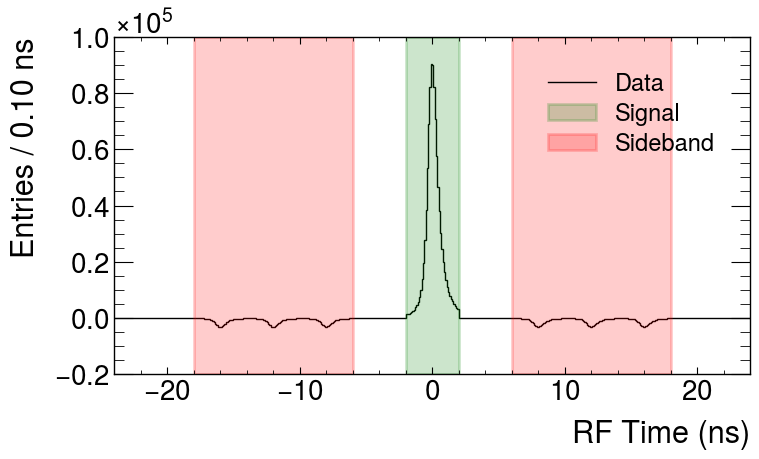

In [66]:
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]

# weights=[1]*len(df1Phase1)
weights=df1Phase1["AccWeight"]
makePlot(df1Phase1,"rfTime",-24,24,0.1,"RF Time (ns)",axes[0],weights,color='black',alpha=1,label="Data")
if is_mc_available: makePlot(df1_mc,"rfTime",-24,24,0.1,"RF Time (ns)",axes[0],[1]*len(df1_mc),scaleFactor=2,color='red',alpha=1,label="MC")
axes[0].axvspan(-2,2,label="Signal",linewidth=2,color='green',alpha=0.2)
axes[0].axvspan(6,18,label="Sideband",linewidth=2,color='red',alpha=0.2)
axes[0].axvspan(-18,-6,color='red',linewidth=2,alpha=0.2)
axes[0].set_ylabel("Entries / %0.2f ns" % (0.1))
axes[0].set_ylim(axes[0].get_ylim()[0],axes[0].get_ylim()[1])
axes[0].legend()#bbox_to_anchor=(0.45,0.9))#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+"/rf_time_subtraction_no_selects_Phase1.pdf")

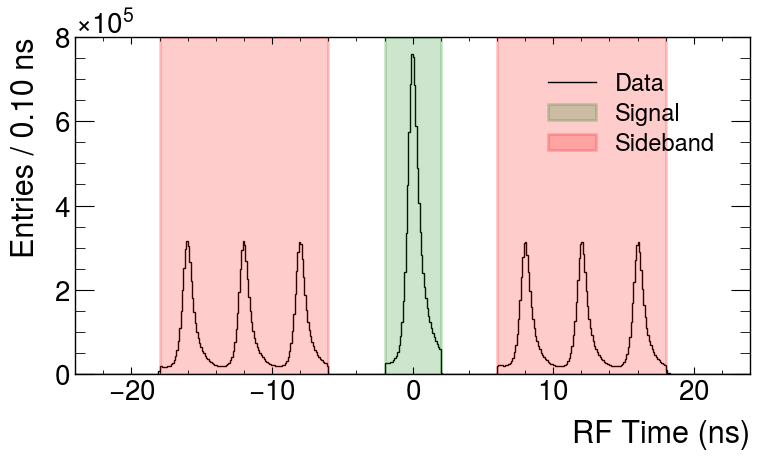

In [42]:
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]

weights=[1]*len(df1Phase2)
# weights=df1Phase2.weightASBS
makePlot(df1Phase2,"rfTime",-24,24,0.1,"RF Time (ns)",axes[0],weights,color='black',alpha=1,label="Data")
if is_mc_available: makePlot(df1_mc,"rfTime",-24,24,0.1,"RF Time (ns)",axes[0],[1]*len(df1_mc),scaleFactor=2,color='red',alpha=1,label="MC")
axes[0].axvspan(-2,2,label="Signal",linewidth=2,color='green',alpha=0.2)
axes[0].axvspan(6,18,label="Sideband",linewidth=2,color='red',alpha=0.2)
axes[0].axvspan(-18,-6,color='red',linewidth=2,alpha=0.2)
axes[0].set_ylabel("Entries / %0.2f ns" % (0.1))
axes[0].set_ylim(axes[0].get_ylim()[0],axes[0].get_ylim()[1])
axes[0].legend()#bbox_to_anchor=(0.45,0.9))#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+"/rf_time_subtraction_no_selects_Phase2.pdf")

## Beam energy selected

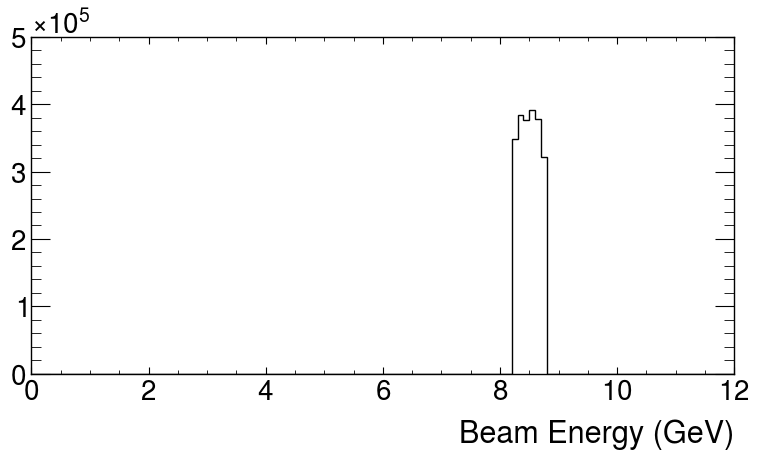

In [43]:
# plot Ebeam from Phase-1
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]
makePlot(df1Phase1,"Ebeam",0,12,0.1,"Beam Energy (GeV)",axes[0],[1]*len(df1Phase1),color='black',alpha=1,label="Data")
plt.tight_layout()

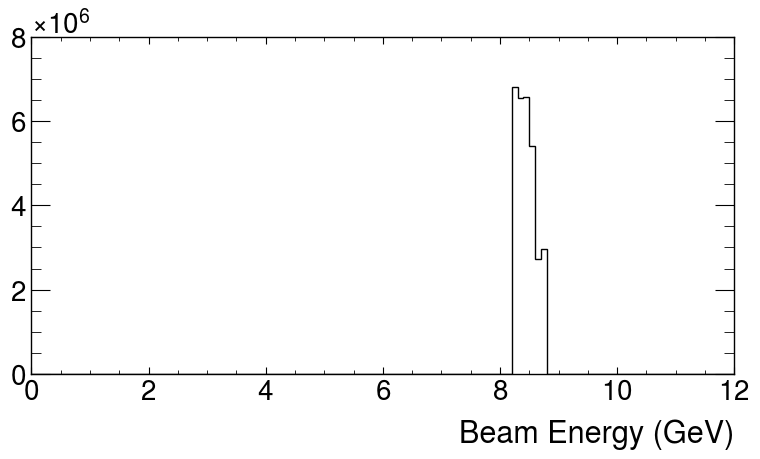

In [44]:
# plot Ebeam from Phase-2
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]
makePlot(df1Phase2,"Ebeam",0,12,0.1,"Beam Energy (GeV)",axes[0],[1]*len(df1Phase2),color='black',alpha=1,label="Data")
plt.tight_layout()

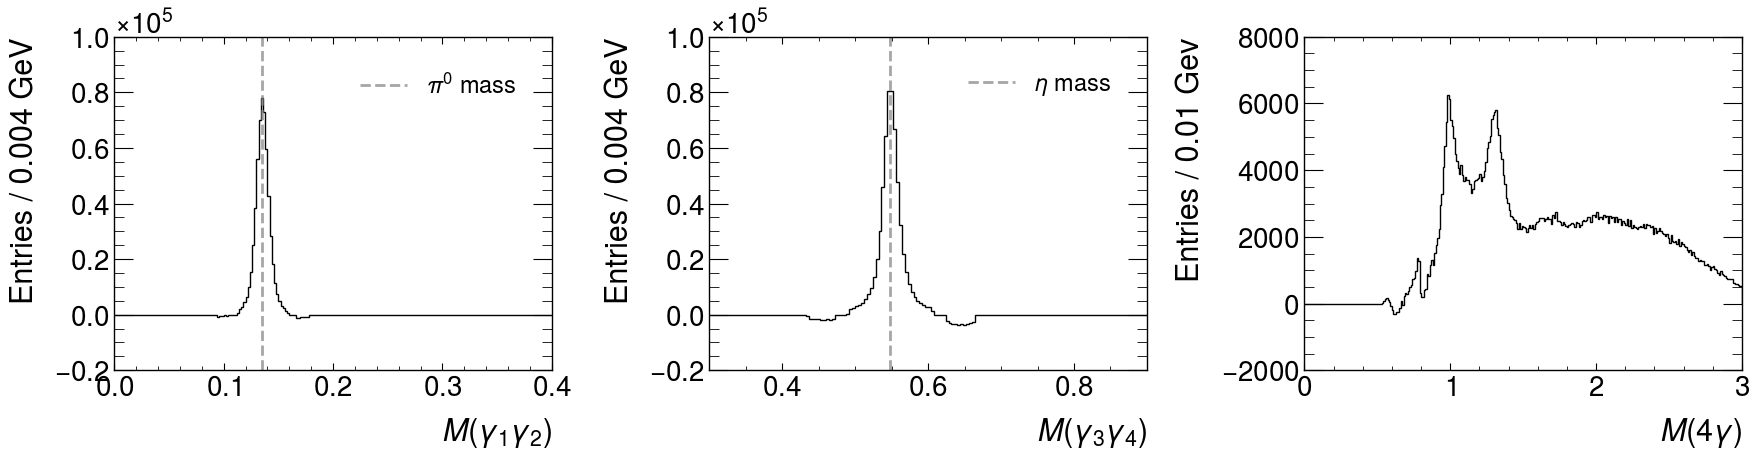

In [45]:
plotDiagnostic(df1Phase1,df1Phase1.weightASBS)

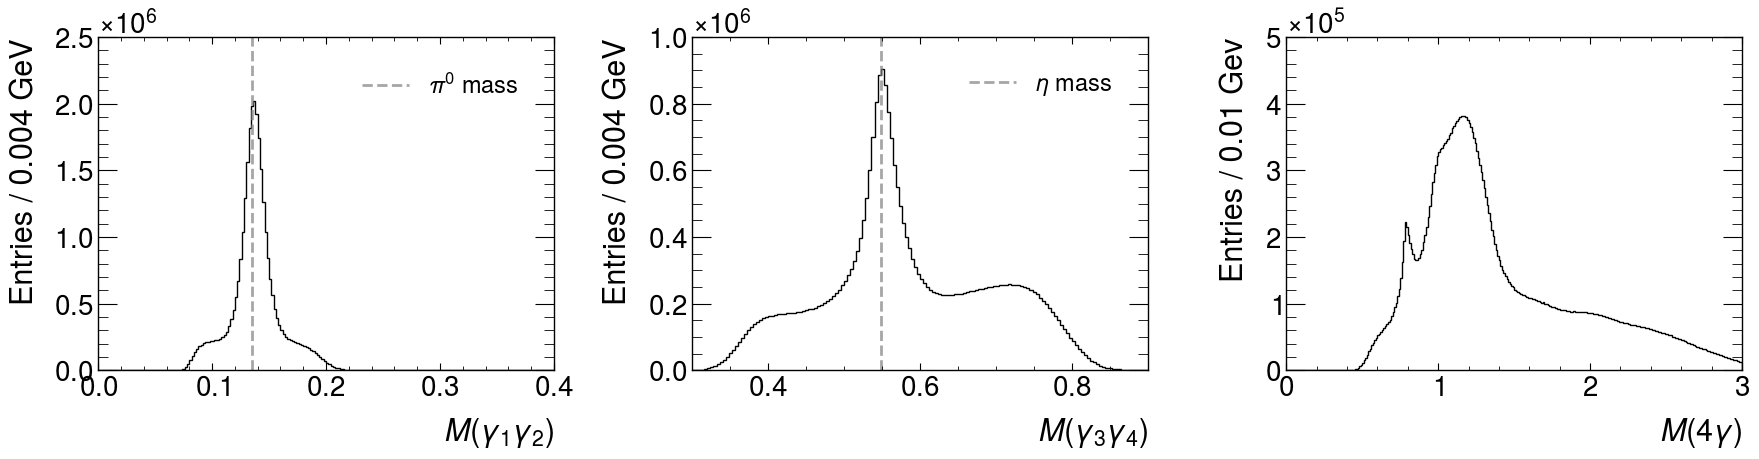

In [46]:
plotDiagnostic(df1Phase2,[1]*len(df1Phase2))

In [47]:
# df1Phase1=df1Phase1[(df1Phase1.Ebeam>8.2)&(df1Phase1.Ebeam<8.8)]
# df1Phase2=df1Phase2[(df1Phase2.Ebeam>8.2)&(df1Phase2.Ebeam<8.8)]
# if is_mc_available: df1_mc=df1_mc[(df1_mc.Ebeam>8.2)&(df1_mc.Ebeam<8.8)]

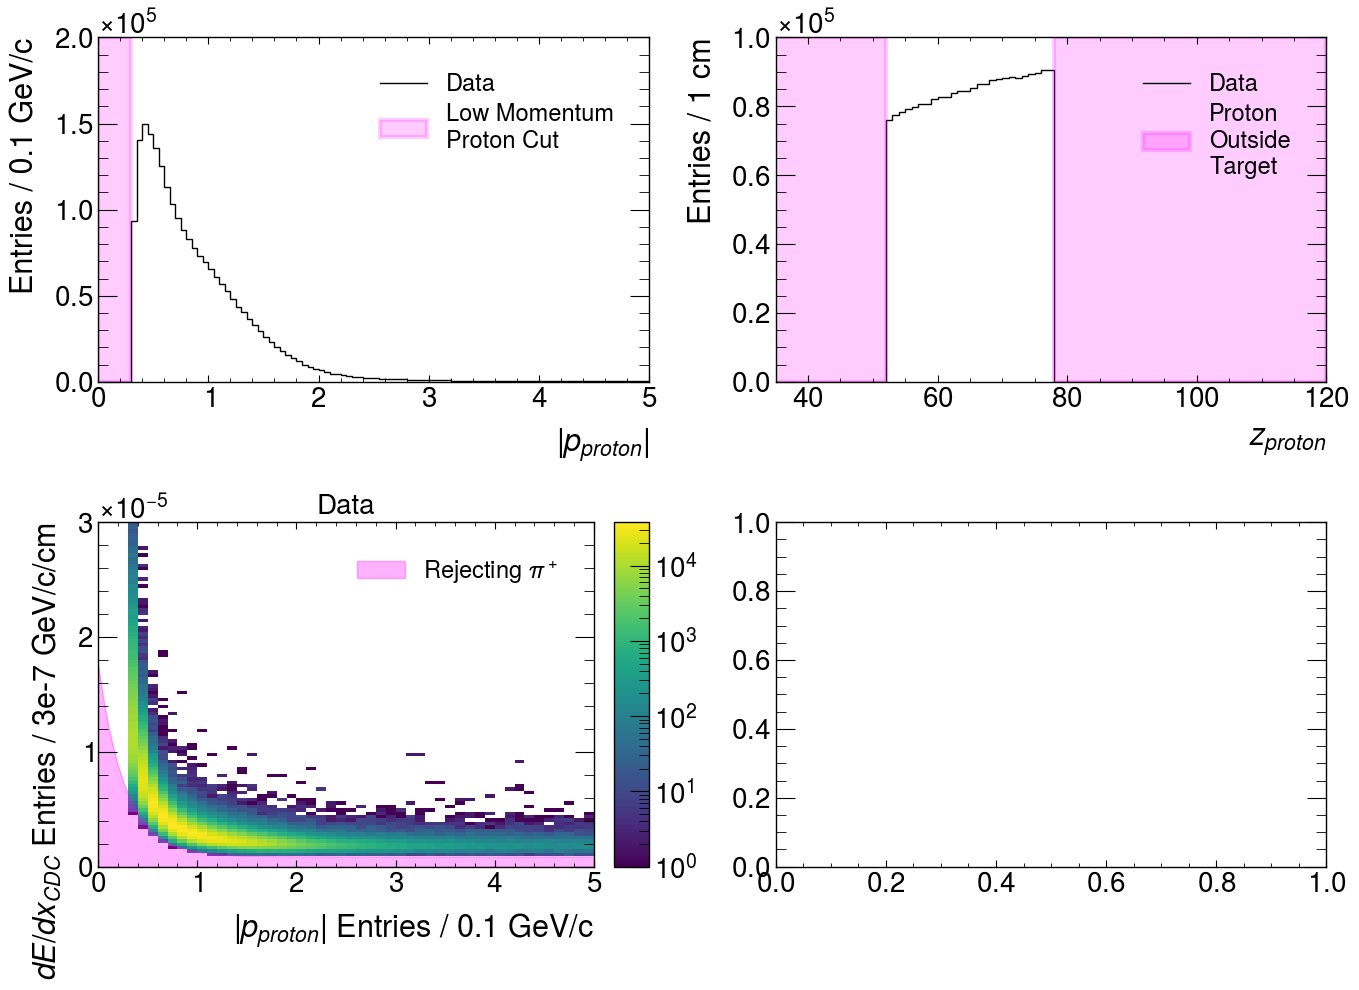

In [48]:
fig,axes=plt.subplots(2,2,figsize=(14,10))
axes=axes.flatten()

weights1=[1]*len(df1Phase1)
# weights_mc=[1]*len(df1_mc)
# weights=df1Phase1.AccWeight
# weights=df1Phase1.weightASBS
if is_mc_available:
    weights_mc=df1_mc.AccWeight
    scaleFactor=2 #scale the MC by this factor to try and match the yields

makePlot(df1Phase1,"proton_momentum",0,5,0.05,r"$|p_{proton}|$",axes[0],weights1,color='black',label="Data")
if is_mc_available: makePlot(df1_mc,"proton_momentum",0,5,0.05,r"$|p_{proton}|$",axes[0],weights_mc,scaleFactor=scaleFactor,color='red',label="MC")
# axes[0].axvspan(0,0.3,label="Low Momentum\nProton Cut",color='red')
denoteRegion(axes[0],0,0.3,False,label="Low Momentum\nProton Cut")
# denoteRegion(axes[0],0.3,axes[0].get_xlim()[1],True,label="Select Protons")
axes[0].set_ylabel("Entries / %0.1f GeV/c" % (0.1))
axes[0].legend()

makePlot(df1Phase1,"proton_z",35,120,1,r"$z_{proton}$",axes[1],weights1,color='black',label="Data")
if is_mc_available: makePlot(df1_mc,"proton_z",35,120,1,r"$z_{proton}$",axes[1],weights_mc,scaleFactor=scaleFactor,color='red',label="MC")
# axes[1].axvspan(0,42,label="Proton In\nTarget",color='red')
# axes[1].axvspan(82,axes[1].get_xlim()[1],color='red')
denoteRegion(axes[1],0,zMin,False,label="Proton\nOutside\nTarget")
denoteRegion(axes[1],zMax,axes[1].get_xlim()[1],False,label="")
# denoteRegion(axes[1],42,82,True,label="Select Protons\nFrom Target")
axes[1].set_ylabel("Entries / %0.0f cm" % (1))
axes[1].legend()

# makePlot(df1,"proton_R",0,5,0.1,r"$R_{proton}$",axes[2],weights,color='black',label="Data")
# #axes[2].axvspan(2,axes[2].get_xlim()[1],label="Proton In Target",color='red')
# denoteRegion(axes[2],2,axes[2].get_xlim()[1],False,label="Proton\nOutside\nTarget")
# # denoteRegion(axes[2],0,2,True,label="Select Protons\nFrom Target")
# axes[2].set_ylabel("Entries / %0.1f cm" % (0.1))
# axes[2].legend()

if is_mc_available:
    for df,weight,label,scaleFactor,iax in zip([df1,df1_mc],[weights,weights_mc],["Data","MC"],[1.0,scaleFactor],range(2,4)):
        makePlot2D(df,"proton_momentum","proton_dEdxCDC",0,5,0.1,0,30e-6,3e-7,axes[iax],True,weight,linewidth=0,rasterized=True,label=label)
        axes[iax].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
        axes[iax].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
        def dEdxCurve(pmag):
            return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
        pmags=np.linspace(*axes[iax].get_xlim(),100)
        axes[iax].fill_between(pmags,dEdxCurve(pmags),label="Rejecting $\pi^+$",color='magenta',alpha=0.3)
        axes[iax].set_title(label)
        axes[iax].legend()
else:
    for df,weight,label,iax in zip([df1Phase1],[weights1],["Data"],range(2,4)):
        makePlot2D(df,"proton_momentum","proton_dEdxCDC",0,5,0.1,0,30e-6,3e-7,axes[iax],True,weight,linewidth=0,rasterized=True,label=label)
        axes[iax].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
        axes[iax].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
        def dEdxCurve(pmag):
            return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
        pmags=np.linspace(*axes[iax].get_xlim(),100)
        axes[iax].fill_between(pmags,dEdxCurve(pmags),label="Rejecting $\pi^+$",color='magenta',alpha=0.3)
        axes[iax].set_title(label)
        axes[iax].legend()
plt.tight_layout()
plt.savefig(resultsFolder+"/proton_cuts_df1Phase1.pdf")

In [49]:
df2Phase2=df1Phase2[(df1Phase2.proton_z>zMin)&(df1Phase2.proton_z<zMax)]

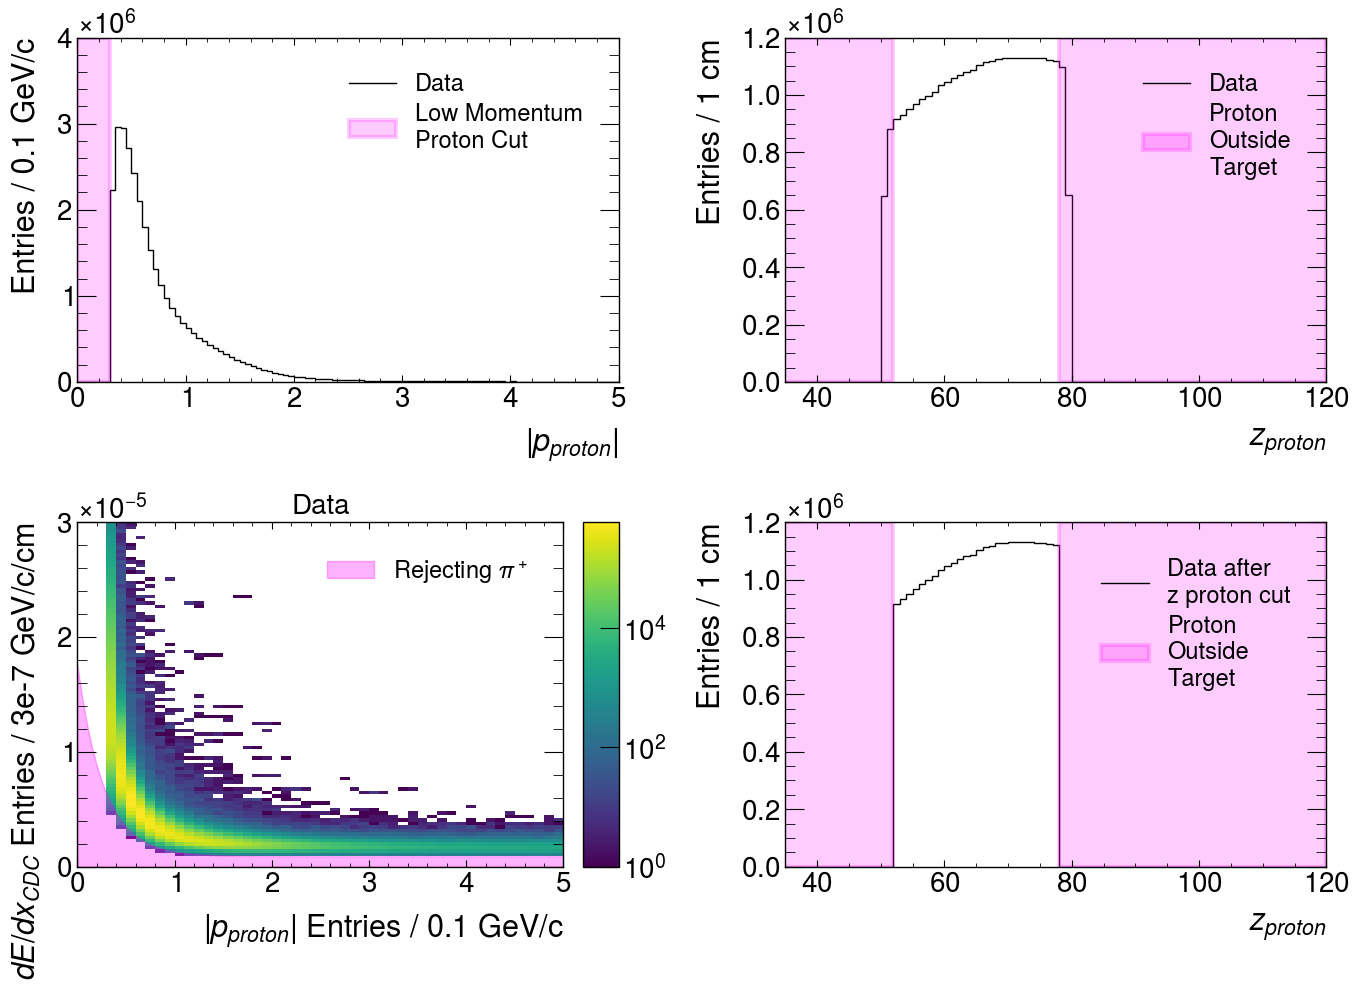

In [50]:
fig,axes=plt.subplots(2,2,figsize=(14,10))
axes=axes.flatten()

weights1=[1]*len(df1Phase2)
# weights_mc=[1]*len(df1_mc)
# weights1=df1Phase2.weightASBS
# if is_mc_available:
#     weights_mc=df1_mc.AccWeight
#     scaleFactor=2 #scale the MC by this factor to try and match the yields

makePlot(df1Phase2,"proton_momentum",0,5,0.05,r"$|p_{proton}|$",axes[0],weights1,color='black',label="Data")
if is_mc_available: makePlot(df1_mc,"proton_momentum",0,5,0.05,r"$|p_{proton}|$",axes[0],weights_mc,scaleFactor=scaleFactor,color='red',label="MC")
# axes[0].axvspan(0,0.3,label="Low Momentum\nProton Cut",color='red')
denoteRegion(axes[0],0,0.3,False,label="Low Momentum\nProton Cut")
# denoteRegion(axes[0],0.3,axes[0].get_xlim()[1],True,label="Select Protons")
axes[0].set_ylabel("Entries / %0.1f GeV/c" % (0.1))
axes[0].legend()

makePlot(df1Phase2,"proton_z",35,120,1,r"$z_{proton}$",axes[1],weights1,color='black',label="Data")
if is_mc_available: makePlot(df1_mc,"proton_z",35,120,1,r"$z_{proton}$",axes[1],weights_mc,scaleFactor=scaleFactor,color='red',label="MC")
# axes[1].axvspan(0,42,label="Proton In\nTarget",color='red')
# axes[1].axvspan(82,axes[1].get_xlim()[1],color='red')
denoteRegion(axes[1],0,zMin,False,label="Proton\nOutside\nTarget")
denoteRegion(axes[1],zMax,axes[1].get_xlim()[1],False,label="")
# denoteRegion(axes[1],42,82,True,label="Select Protons\nFrom Target")
axes[1].set_ylabel("Entries / %0.0f cm" % (1))
axes[1].legend()

weights2=[1]*len(df2Phase2)
makePlot(df2Phase2,"proton_z",35,120,1,r"$z_{proton}$",axes[3],weights2,color='black',label="Data after\nz proton cut")
denoteRegion(axes[3],0,zMin,False,label="Proton\nOutside\nTarget")
denoteRegion(axes[3],zMax,axes[3].get_xlim()[1],False,label="")

axes[3].set_ylabel("Entries / %0.0f cm" % (1))
axes[3].legend()

# makePlot(df1,"proton_R",0,5,0.1,r"$R_{proton}$",axes[2],weights,color='black',label="Data")
# #axes[2].axvspan(2,axes[2].get_xlim()[1],label="Proton In Target",color='red')
# denoteRegion(axes[2],2,axes[2].get_xlim()[1],False,label="Proton\nOutside\nTarget")
# # denoteRegion(axes[2],0,2,True,label="Select Protons\nFrom Target")
# axes[2].set_ylabel("Entries / %0.1f cm" % (0.1))
# axes[2].legend()

if is_mc_available:
    for df,weight,label,scaleFactor,iax in zip([df1,df1_mc],[weights,weights_mc],["Data","MC"],[1.0,scaleFactor],range(2,4)):
        makePlot2D(df,"proton_momentum","proton_dEdxCDC",0,5,0.1,0,30e-6,3e-7,axes[iax],True,weight,linewidth=0,rasterized=True,label=label)
        axes[iax].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
        axes[iax].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
        def dEdxCurve(pmag):
            return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
        pmags=np.linspace(*axes[iax].get_xlim(),100)
        axes[iax].fill_between(pmags,dEdxCurve(pmags),label="Rejecting $\pi^+$",color='magenta',alpha=0.3)
        axes[iax].set_title(label)
        axes[iax].legend()
else:
    for df,weight,label,iax in zip([df1Phase2],[weights1],["Data"],range(2,4)):
        makePlot2D(df,"proton_momentum","proton_dEdxCDC",0,5,0.1,0,30e-6,3e-7,axes[iax],True,weight,linewidth=0,rasterized=True,label=label)
        axes[iax].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
        axes[iax].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
        def dEdxCurve(pmag):
            return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
        pmags=np.linspace(*axes[iax].get_xlim(),100)
        axes[iax].fill_between(pmags,dEdxCurve(pmags),label="Rejecting $\pi^+$",color='magenta',alpha=0.3)
        axes[iax].set_title(label)
        axes[iax].legend()
plt.tight_layout()
plt.savefig(resultsFolder+"/proton_cuts_df1Phase2.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


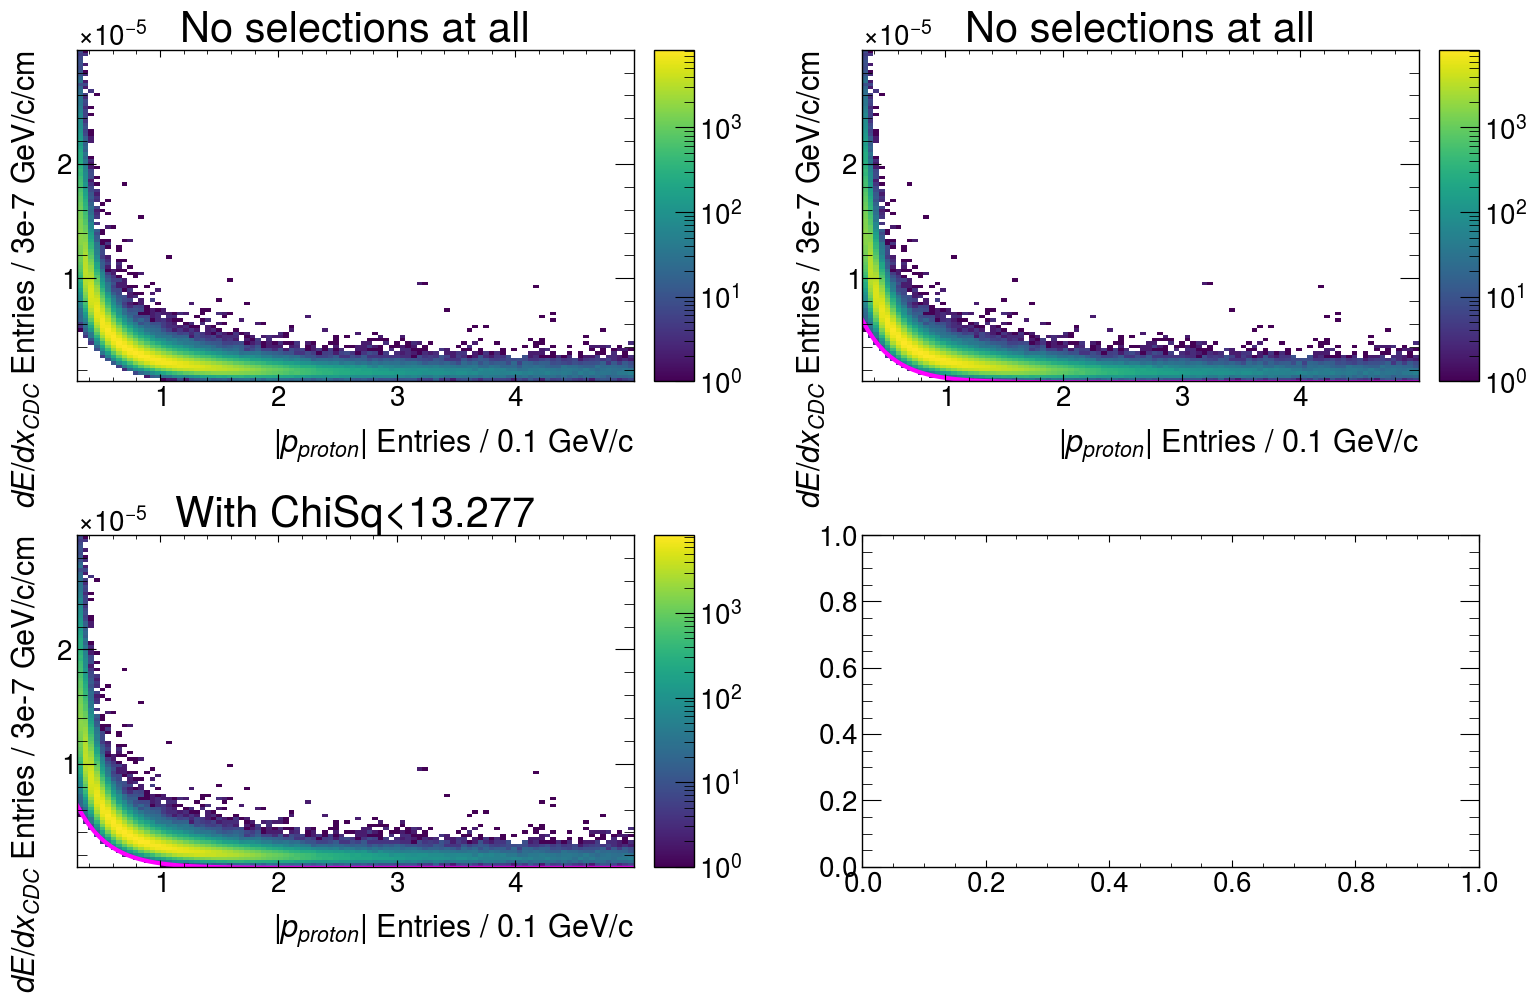

In [51]:
def dEdxCurve(pmag):
    return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
def dEdxCurve_nom(pmag):
    return 1e-6*(np.exp(-4*pmag+2.25)+1.0)

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

tmp=df1Phase1.sample(1000000)
tmp=tmp[(tmp["proton_momentum"]<5)&(tmp["proton_dEdxCDC"]<3e-5)]
hep.hist2dplot(np.histogram2d(tmp["proton_momentum"],tmp["proton_dEdxCDC"],bins=(100,100)),ax=axes[0],norm=mpl.colors.LogNorm())
axes[0].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
axes[0].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
axes[0].set_title("No selections at all",size=30)
axes[0].legend()

tmp=tmp[(tmp["proton_momentum"]<5)&(tmp["proton_dEdxCDC"]<3e-5)]
hep.hist2dplot(np.histogram2d(tmp["proton_momentum"],tmp["proton_dEdxCDC"],bins=(100,100)),ax=axes[1],norm=mpl.colors.LogNorm())
axes[1].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
axes[1].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
pmags=np.linspace(*axes[1].get_xlim(),100)
axes[1].plot(pmags,dEdxCurve(pmags),color='magenta',alpha=1,linewidth=3)
# axes[1].plot(pmags,dEdxCurve_nom(pmags),label="nominal",color='orange',alpha=1,linewidth=3)
axes[1].set_title("No selections at all",size=30)
axes[1].legend()

tmp=tmp[tmp["chiSq"]<13.277]
hep.hist2dplot(np.histogram2d(tmp["proton_momentum"],tmp["proton_dEdxCDC"],bins=(100,100)),ax=axes[2],norm=mpl.colors.LogNorm())
axes[2].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
axes[2].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
pmags=np.linspace(*axes[2].get_xlim(),100)
axes[2].plot(pmags,dEdxCurve(pmags),color='magenta',alpha=1,linewidth=3)
# axes[2].plot(pmags,dEdxCurve_nom(pmags),label="nominal",color='orange',alpha=1,linewidth=3)
axes[2].set_title("With ChiSq<13.277",size=30)
axes[2].legend()

plt.tight_layout()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


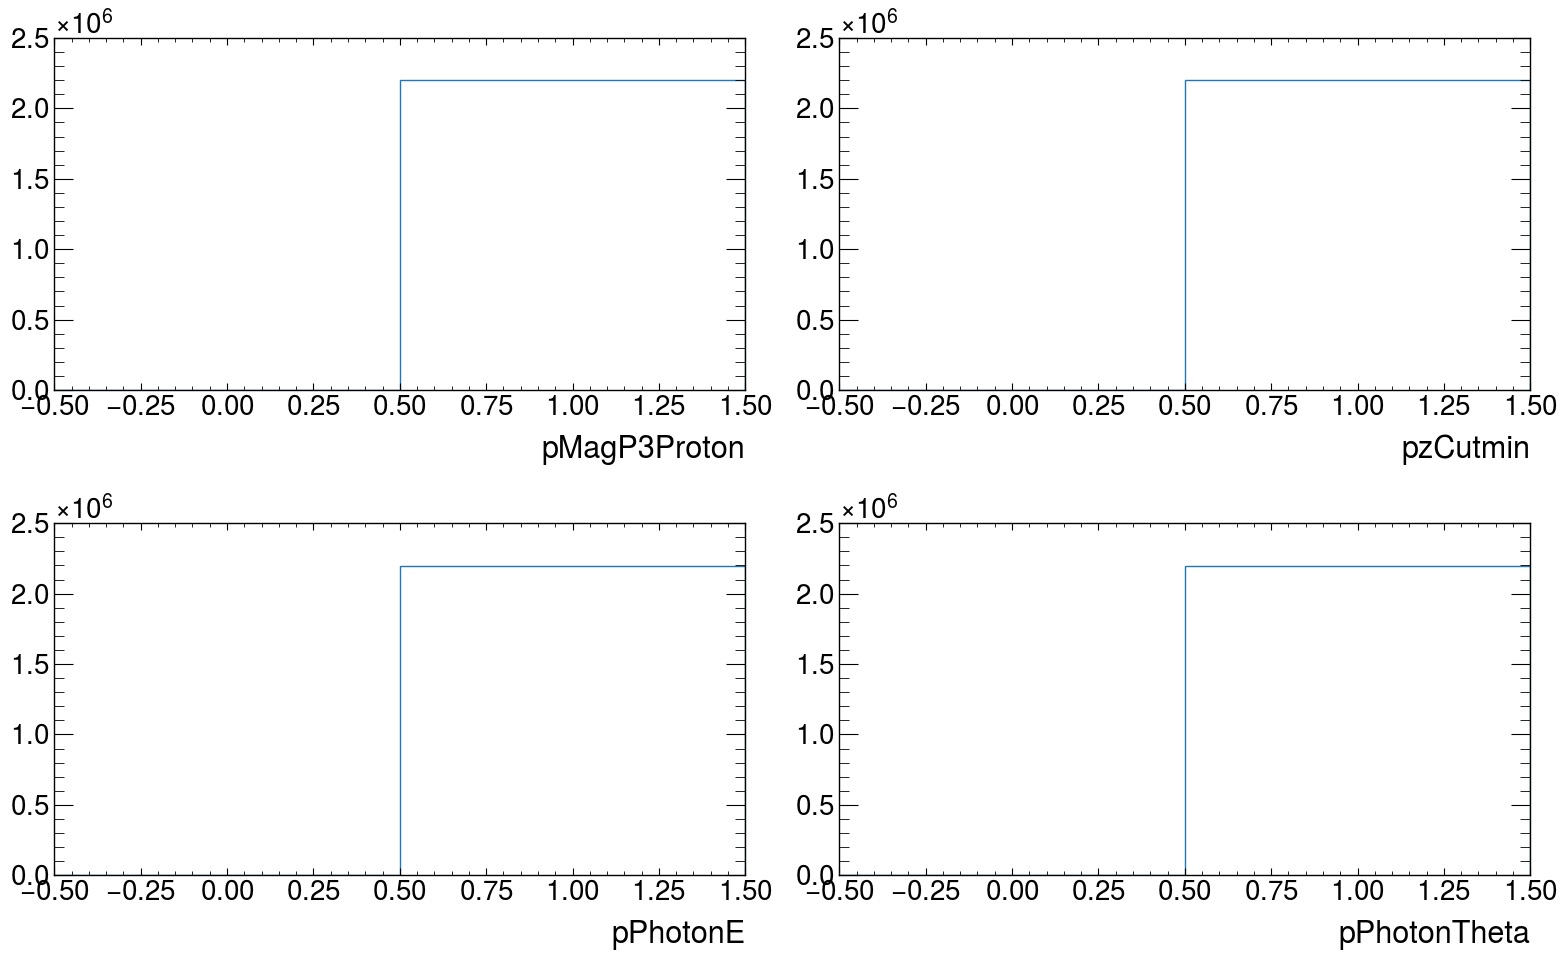

In [52]:
fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()
makePlot(df1Phase1,"pMagP3Proton",-0.5,1.5,1.0,r"pMagP3Proton",axes[0],[1]*len(df1Phase1),label="Data")
makePlot(df1Phase1,"pzCutmin",-0.5,1.5,1.0,r"pzCutmin",axes[1],[1]*len(df1Phase1),label="Data")
# makePlot(df1Phase1,"pdEdxCDCProton",-0.5,1.5,1.0,r"pdEdxCDCProton",axes[2],[1]*len(df1Phase1),label="Data")
makePlot(df1Phase1,"pPhotonE",-0.5,1.5,1.0,r"pPhotonE",axes[2],[1]*len(df1Phase1),label="Data")
makePlot(df1Phase1,"pPhotonTheta",-0.5,1.5,1.0,r"pPhotonTheta",axes[3],[1]*len(df1Phase1),label="Data") 
plt.tight_layout()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


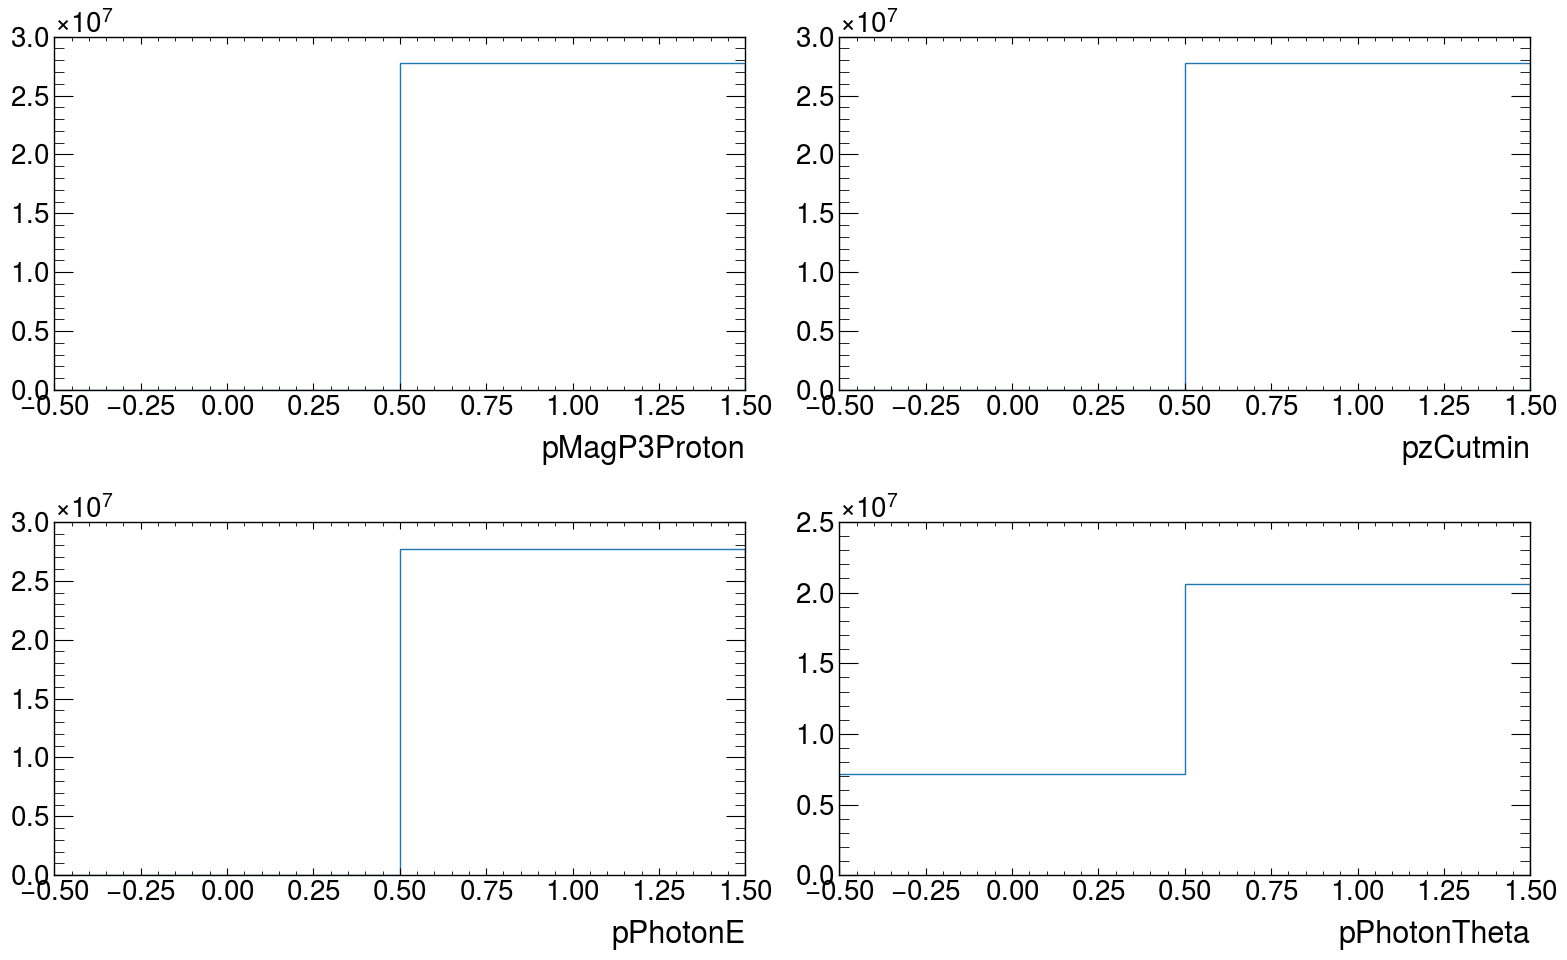

In [53]:
fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()
makePlot(df2Phase2,"pMagP3Proton",-0.5,1.5,1.0,r"pMagP3Proton",axes[0],[1]*len(df2Phase2),label="Data")
makePlot(df2Phase2,"pzCutmin",-0.5,1.5,1.0,r"pzCutmin",axes[1],[1]*len(df2Phase2),label="Data")
makePlot(df2Phase2,"pPhotonE",-0.5,1.5,1.0,r"pPhotonE",axes[2],[1]*len(df2Phase2),label="Data")
# makePlot(df2Phase2,"pdEdxCDCProton",-0.5,1.5,1.0,r"pdEdxCDCProton",axes[2],[1]*len(df2Phase2),label="Data")
makePlot(df2Phase2,"pPhotonTheta",-0.5,1.5,1.0,r"pPhotonTheta",axes[3],[1]*len(df2Phase2),label="Data") 
plt.tight_layout()

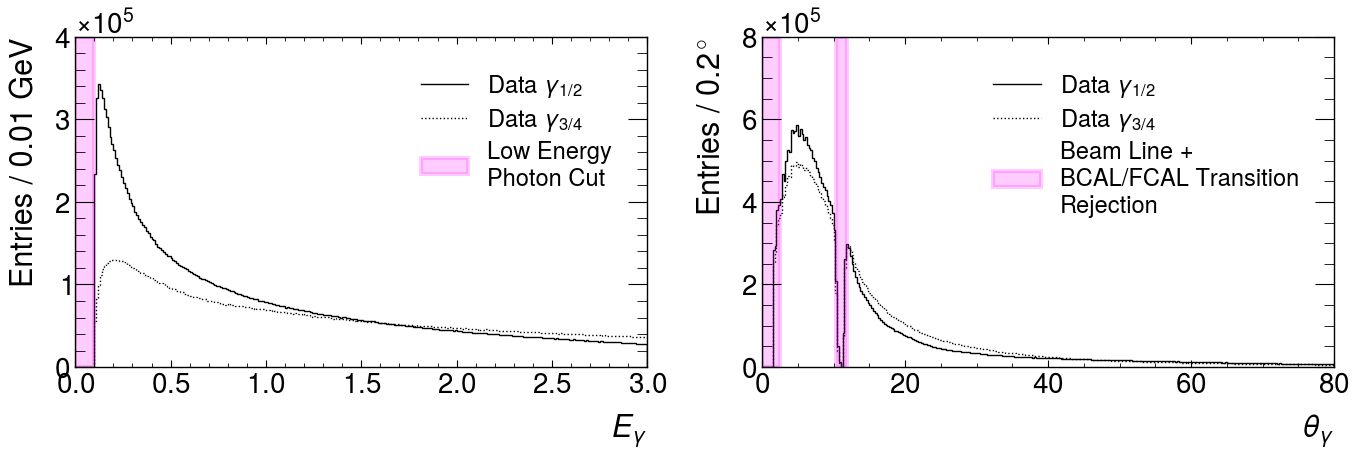

In [54]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
axes=axes.flatten()

weights=[1]*len(df2Phase2)
# weights=df2.AccWeight
# if is_mc_available: weights_mc=df2_mc.AccWeight

makePlot(df2Phase2,"photonE1",0,3,0.01,r"$E_{\gamma}$",axes[0],weights,color='black',alpha=1,label="Data $\gamma_{1/2}$")
makePlot(df2Phase2,"photonE3",0,3,0.01,r"$E_{\gamma}$",axes[0],weights,color='black',linestyle='dotted',alpha=1,label="Data $\gamma_{3/4}$")
# if is_mc_available:
#     makePlot(df2_mc,"photonE1",0,3,0.01,r"$E_{\gamma}$",axes[0],weights_mc,scaleFactor=4,color='red',alpha=1,label="MC $\gamma_{1/2}$")
#     makePlot(df2_mc,"photonE3",0,3,0.01,r"$E_{\gamma}$",axes[0],weights_mc,scaleFactor=4,color='red',linestyle='dotted',alpha=1,label="MC $\gamma_{3/4}$")
#axes[0].axvspan(0,Ecut,label="Low Energy\nPhoton Cut",color='red',alpha=0.4)
denoteRegion(axes[0],0,Ecut,False,label="Low Energy\nPhoton Cut")
axes[0].set_ylabel("Entries / %0.2f GeV" % (0.01))
axes[0].legend()#prop={"size":24})


makePlot(df2Phase2,"photonTheta1",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights,color='black',alpha=1,label="Data $\gamma_{1/2}$")
makePlot(df2Phase2,"photonTheta3",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights,color='black',linestyle='dotted',alpha=1,label="Data $\gamma_{3/4}$")
# if is_mc_available:
#     makePlot(df2_mc,"photonTheta1",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights_mc,color='red',alpha=1,label="MC $\gamma_{1/2}$")
#     makePlot(df2_mc,"photonTheta3",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights_mc,color='red',linestyle='dotted',alpha=1,label="MC $\gamma_{3/4}$")
# axes[1].axvspan(0,thetaLow,color='red',alpha=0.4,label="Beam Line +\nBCAL/FCAL Transition\nRejection")
# axes[1].axvspan(thetaMed,thetaHig,label="",color='red',alpha=0.4)
denoteRegion(axes[1],0,thetaLow,False,label="Beam Line +\nBCAL/FCAL Transition\nRejection")
denoteRegion(axes[1],thetaMed,thetaHig,False,label="")
axes[1].set_ylabel("Entries / %0.1f$^\circ$" % (0.25))
axes[1].legend()

plt.tight_layout()
plt.savefig(resultsFolder+"/before_photon_cuts.pdf")

## Apply photon selections

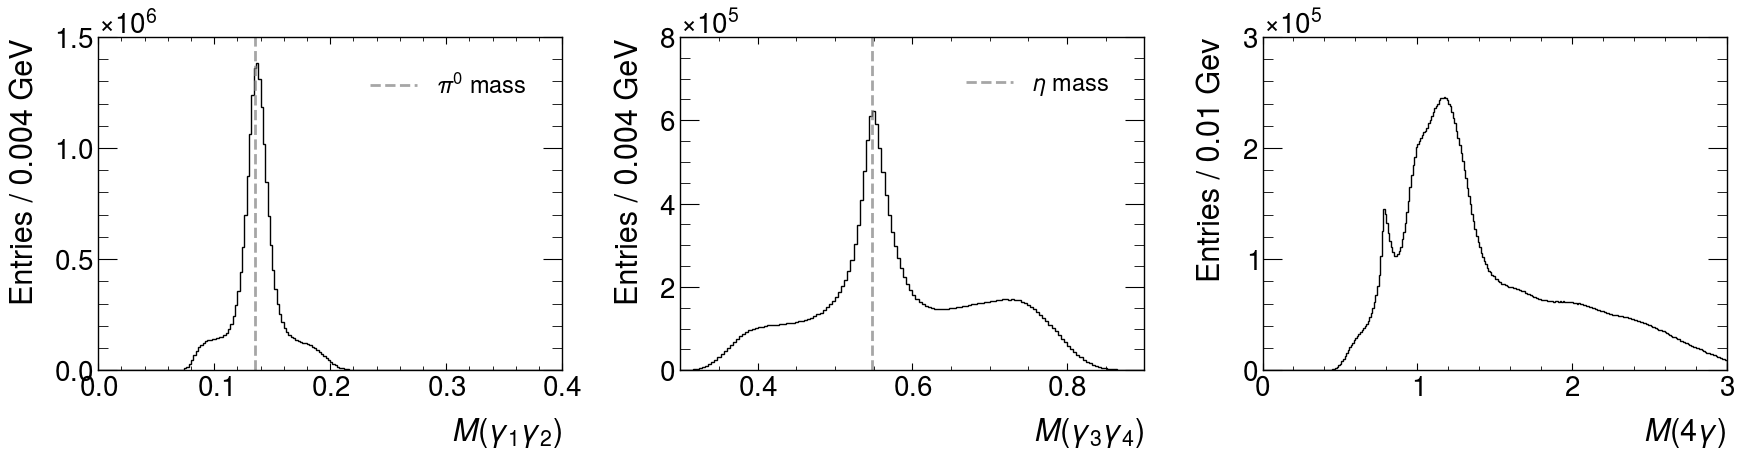

In [55]:
# From DSelector
# pMagP3Proton is boolean
# pzCutmin is boolean
# pdEdxCDCProton is boolean
# pPhotonTheta is boolean if 0 reject, if 1 accept (remove from transition of the BCAL and FCAl)

df3Phase2=df2Phase2[(df2Phase2.pPhotonTheta==True)]
plotDiagnostic(df3Phase2,[1]*len(df3Phase2))

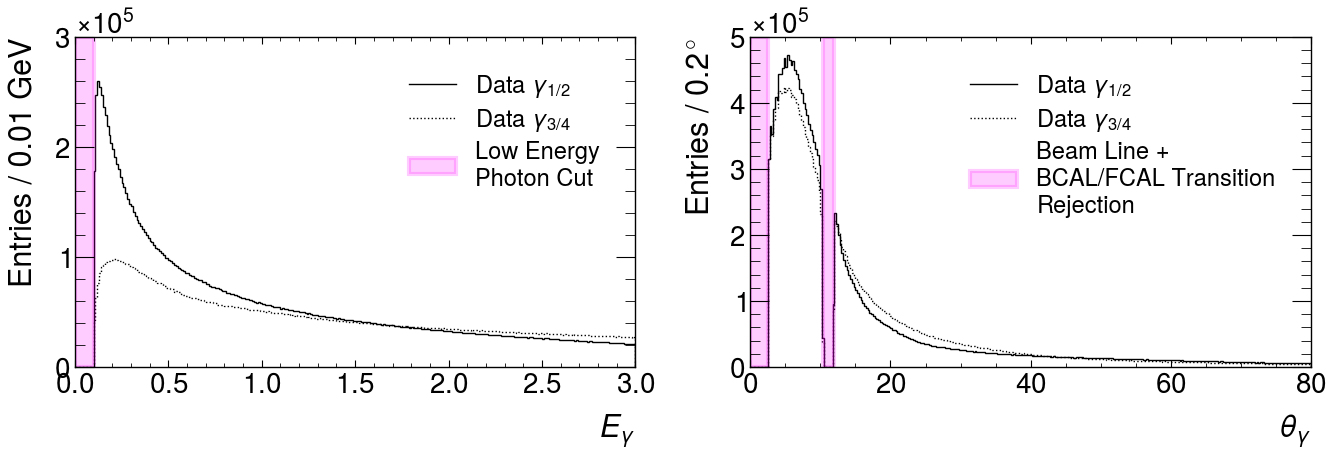

In [56]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
axes=axes.flatten()

weights=[1]*len(df3Phase2)
# weights=df2.AccWeight
# if is_mc_available: weights_mc=df2_mc.AccWeight

makePlot(df3Phase2,"photonE1",0,3,0.01,r"$E_{\gamma}$",axes[0],weights,color='black',alpha=1,label="Data $\gamma_{1/2}$")
makePlot(df3Phase2,"photonE3",0,3,0.01,r"$E_{\gamma}$",axes[0],weights,color='black',linestyle='dotted',alpha=1,label="Data $\gamma_{3/4}$")
# if is_mc_available:
#     makePlot(df2_mc,"photonE1",0,3,0.01,r"$E_{\gamma}$",axes[0],weights_mc,scaleFactor=4,color='red',alpha=1,label="MC $\gamma_{1/2}$")
#     makePlot(df2_mc,"photonE3",0,3,0.01,r"$E_{\gamma}$",axes[0],weights_mc,scaleFactor=4,color='red',linestyle='dotted',alpha=1,label="MC $\gamma_{3/4}$")
#axes[0].axvspan(0,Ecut,label="Low Energy\nPhoton Cut",color='red',alpha=0.4)
denoteRegion(axes[0],0,Ecut,False,label="Low Energy\nPhoton Cut")
axes[0].set_ylabel("Entries / %0.2f GeV" % (0.01))
axes[0].legend()#prop={"size":24})


makePlot(df3Phase2,"photonTheta1",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights,color='black',alpha=1,label="Data $\gamma_{1/2}$")
makePlot(df3Phase2,"photonTheta3",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights,color='black',linestyle='dotted',alpha=1,label="Data $\gamma_{3/4}$")
# if is_mc_available:
#     makePlot(df2_mc,"photonTheta1",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights_mc,color='red',alpha=1,label="MC $\gamma_{1/2}$")
#     makePlot(df2_mc,"photonTheta3",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights_mc,color='red',linestyle='dotted',alpha=1,label="MC $\gamma_{3/4}$")
# axes[1].axvspan(0,thetaLow,color='red',alpha=0.4,label="Beam Line +\nBCAL/FCAL Transition\nRejection")
# axes[1].axvspan(thetaMed,thetaHig,label="",color='red',alpha=0.4)
denoteRegion(axes[1],0,thetaLow,False,label="Beam Line +\nBCAL/FCAL Transition\nRejection")
denoteRegion(axes[1],thetaMed,thetaHig,False,label="")
axes[1].set_ylabel("Entries / %0.1f$^\circ$" % (0.25))
axes[1].legend()

plt.tight_layout()
plt.savefig(resultsFolder+"/after_photon_cuts.pdf")

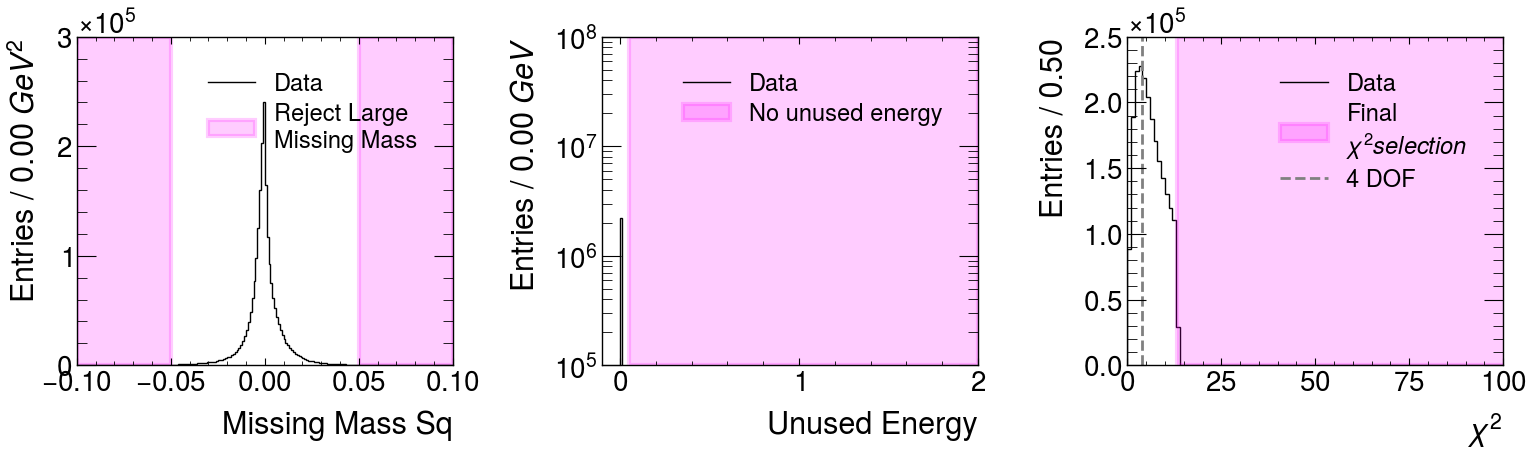

In [57]:
fig,axes=plt.subplots(1,3,figsize=(16,5))

weights=[1]*len(df1Phase1)
# weights=df1Phase1.AccWeight
# if is_mc_available: weights_mc=df3_mc.AccWeight

makePlot(df1Phase1,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights_mc,scaleFactor=0.3,color='red',alpha=1,label="MC")
# axes[0].axvspan(-0.1,-0.05,label="Reject Large\nMissing Mass",color='red',alpha=0.4)
# axes[0].axvspan(0.05,0.1,color='red',alpha=0.4)
denoteRegion(axes[0],-0.1,-0.05,False,label="Reject Large\nMissing Mass")
denoteRegion(axes[0],0.05,0.1,False)
axes[0].set_ylabel("Entries / %0.2f $GeV^2$" % (0.001))
axes[0].legend()#prop={"size":24})

makePlot(df1Phase1,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights_mc,scaleFactor=5,color='red',alpha=1,label="MC")
#axes[1].axvspan(looseUE,2,color='red',alpha=0.4,label="Loosely\nenforce\nshower\nquantity")
denoteRegion(axes[1],looseUE,2,False,label="No unused energy")
axes[1].set_ylabel("Entries / %0.2f $GeV$" % (0.001))
axes[1].set_yscale('log')
axes[1].legend()#prop={"size":24})

makePlot(df1Phase1,"chiSq",0,100,1,"$\chi^2$",axes[2],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"chiSq",0,100,1,"$\chi^2$",axes[2],weights_mc,scaleFactor=0.15,color='red',alpha=1,label="MC")
#axes[2].axvspan(looseChiSq,300,color='red',alpha=0.4,label="Loose\n$\chi^2 selection$")
denoteRegion(axes[2],13.3,300,False,label="Final\n$\chi^2 selection$")
axes[2].set_ylabel("Entries / %0.2f" % (0.5))
axes[2].axvline(4,c='gray',linestyle='--',label="4 DOF")
axes[2].legend()#prop={"size":24})

plt.tight_layout()

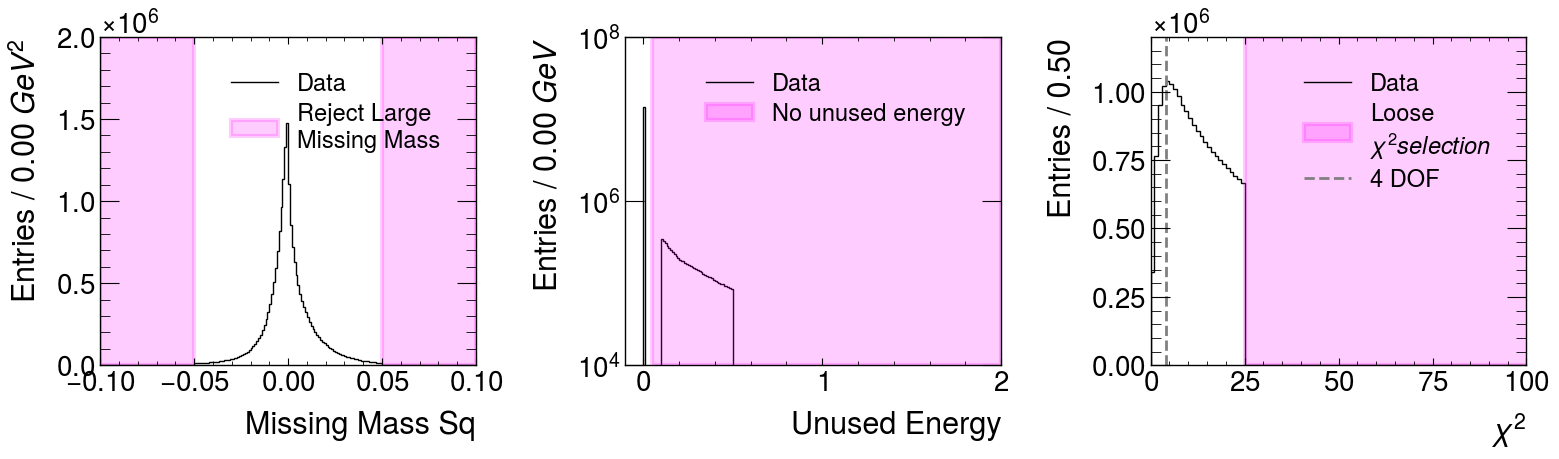

In [58]:
fig,axes=plt.subplots(1,3,figsize=(16,5))

weights=[1]*len(df3Phase2)
# weights=df3Phase2.AccWeight
# if is_mc_available: weights_mc=df3_mc.AccWeight

makePlot(df3Phase2,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights_mc,scaleFactor=0.3,color='red',alpha=1,label="MC")
# axes[0].axvspan(-0.1,-0.05,label="Reject Large\nMissing Mass",color='red',alpha=0.4)
# axes[0].axvspan(0.05,0.1,color='red',alpha=0.4)
denoteRegion(axes[0],-0.1,-0.05,False,label="Reject Large\nMissing Mass")
denoteRegion(axes[0],0.05,0.1,False)
axes[0].set_ylabel("Entries / %0.2f $GeV^2$" % (0.001))
axes[0].legend()#prop={"size":24})

makePlot(df3Phase2,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights_mc,scaleFactor=5,color='red',alpha=1,label="MC")
#axes[1].axvspan(looseUE,2,color='red',alpha=0.4,label="Loosely\nenforce\nshower\nquantity")
denoteRegion(axes[1],looseUE,2,False,label="No unused energy")
axes[1].set_ylabel("Entries / %0.2f $GeV$" % (0.001))
axes[1].set_yscale('log')
axes[1].legend()#prop={"size":24})

makePlot(df3Phase2,"chiSq",0,100,1,"$\chi^2$",axes[2],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"chiSq",0,100,1,"$\chi^2$",axes[2],weights_mc,scaleFactor=0.15,color='red',alpha=1,label="MC")
#axes[2].axvspan(looseChiSq,300,color='red',alpha=0.4,label="Loose\n$\chi^2 selection$")
denoteRegion(axes[2],looseChiSq,300,False,label="Loose\n$\chi^2 selection$")
axes[2].set_ylabel("Entries / %0.2f" % (0.5))
axes[2].axvline(4,c='gray',linestyle='--',label="4 DOF")
axes[2].legend()#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+"/before_exclusivity_cuts.pdf")

In [59]:
# plt.title("Minimal events large MMSq")
# tmp_df=df3[(df3.chiSq<looseChiSq)&(df3.unusedEnergy<0.05)]
# hep.histplot(np.histogram(tmp_df.mmsq, bins=75))
# plt.tight_layout()
# plt.axvline(0.05,c='red',linestyle='--')
# plt.axvline(-0.05,c='red',linestyle='--')
# plt.xlabel("MMSq")

## Apply exclusivity selections - following Phase-1

In [60]:
df4Phase2=df3Phase2[(df3Phase2.unusedEnergy<0.05)&(df3Phase2.chiSq<13.3)]

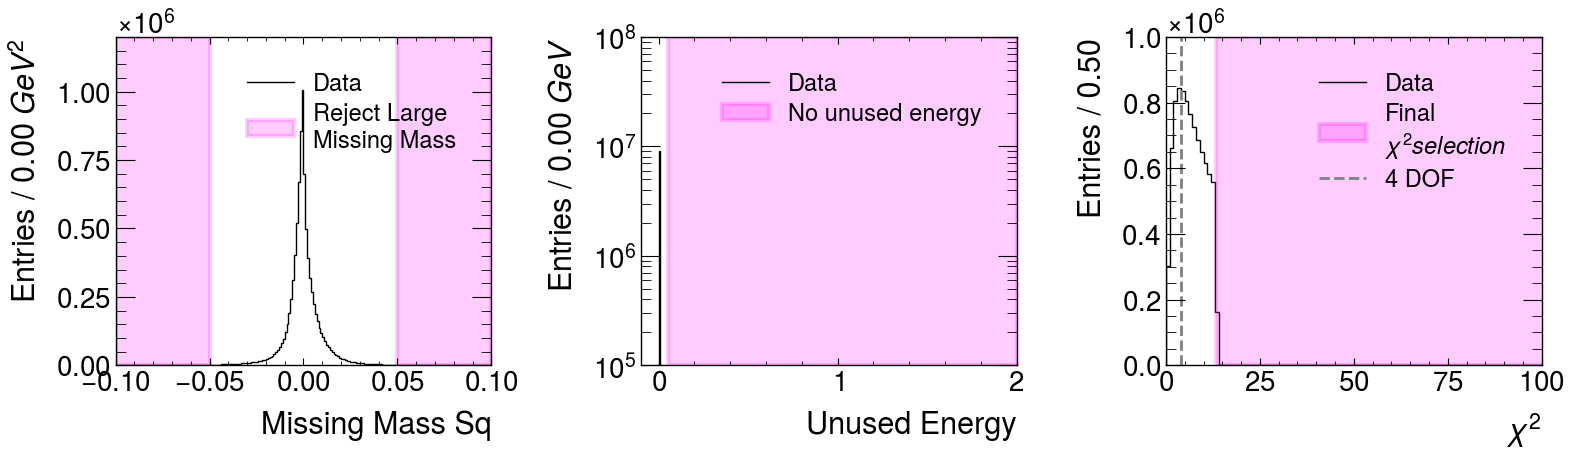

In [61]:
fig,axes=plt.subplots(1,3,figsize=(16,5))

weights=[1]*len(df4Phase2)
# weights=df4Phase2.AccWeight
# if is_mc_available: weights_mc=df3_mc.AccWeight

makePlot(df4Phase2,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights_mc,scaleFactor=0.3,color='red',alpha=1,label="MC")
# axes[0].axvspan(-0.1,-0.05,label="Reject Large\nMissing Mass",color='red',alpha=0.4)
# axes[0].axvspan(0.05,0.1,color='red',alpha=0.4)
denoteRegion(axes[0],-0.1,-0.05,False,label="Reject Large\nMissing Mass")
denoteRegion(axes[0],0.05,0.1,False)
axes[0].set_ylabel("Entries / %0.2f $GeV^2$" % (0.001))
axes[0].legend()#prop={"size":24})

makePlot(df4Phase2,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights_mc,scaleFactor=5,color='red',alpha=1,label="MC")
#axes[1].axvspan(looseUE,2,color='red',alpha=0.4,label="Loosely\nenforce\nshower\nquantity")
denoteRegion(axes[1],looseUE,2,False,label="No unused energy")
axes[1].set_ylabel("Entries / %0.2f $GeV$" % (0.001))
axes[1].set_yscale('log')
axes[1].legend()#prop={"size":24})

makePlot(df4Phase2,"chiSq",0,100,1,"$\chi^2$",axes[2],weights,color='black',alpha=1,label="Data")
# if is_mc_available: makePlot(df3_mc,"chiSq",0,100,1,"$\chi^2$",axes[2],weights_mc,scaleFactor=0.15,color='red',alpha=1,label="MC")
#axes[2].axvspan(looseChiSq,300,color='red',alpha=0.4,label="Loose\n$\chi^2 selection$")
denoteRegion(axes[2],13.3,300,False,label="Final\n$\chi^2 selection$")
axes[2].set_ylabel("Entries / %0.2f" % (0.5))
axes[2].axvline(4,c='gray',linestyle='--',label="4 DOF")
axes[2].legend()#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+"/after_exclusivity_cuts.pdf")

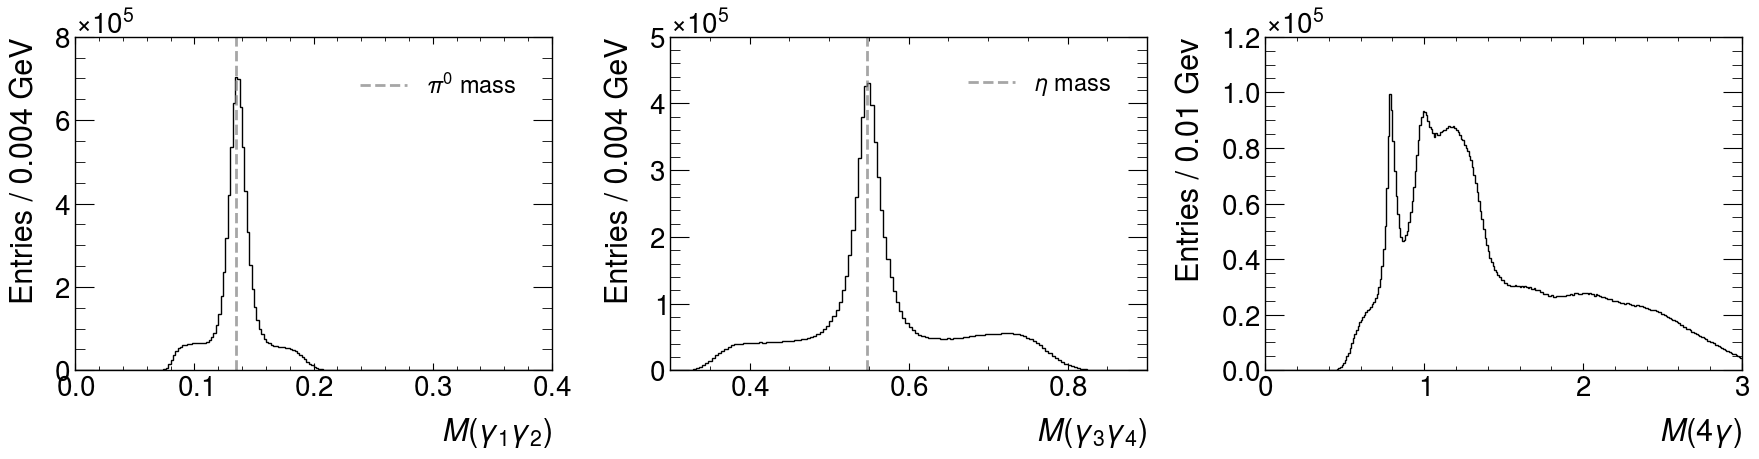

In [62]:
plotDiagnostic(df4Phase2,[1]*len(df4Phase2))

In [63]:
df5Phase2=df4Phase2
df5Phase2.loc[abs(df5Phase2['rfTime'])>2.5,'AccWeight'] = 0.
df5Phase2.loc[df5Phase2['AccWeight']==0,'weightASBS'] = 0.

/d/home/septian/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/d/home/septian/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


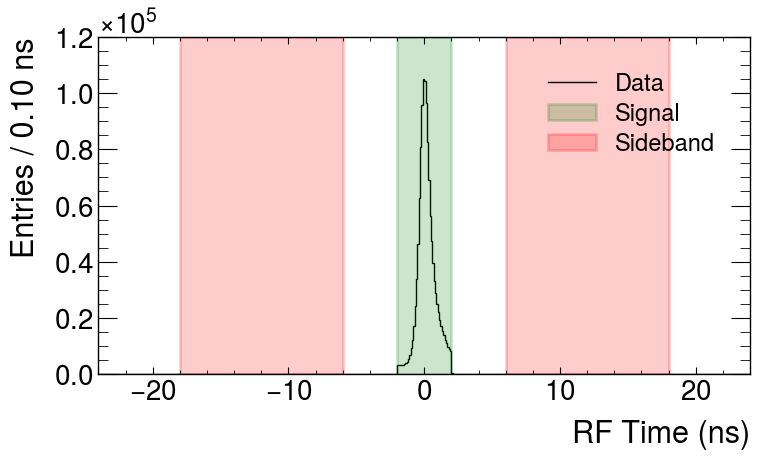

In [64]:
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]

# weights=[1]*len(df5Phase2)
weights=df5Phase2.weightASBS
makePlot(df5Phase2,"rfTime",-24,24,0.1,"RF Time (ns)",axes[0],weights,color='black',alpha=1,label="Data")
if is_mc_available: makePlot(df1_mc,"rfTime",-24,24,0.1,"RF Time (ns)",axes[0],[1]*len(df1_mc),scaleFactor=2,color='red',alpha=1,label="MC")
axes[0].axvspan(-2,2,label="Signal",linewidth=2,color='green',alpha=0.2)
axes[0].axvspan(6,18,label="Sideband",linewidth=2,color='red',alpha=0.2)
axes[0].axvspan(-18,-6,color='red',linewidth=2,alpha=0.2)
axes[0].set_ylabel("Entries / %0.2f ns" % (0.1))
axes[0].set_ylim(axes[0].get_ylim()[0],axes[0].get_ylim()[1])
axes[0].legend()#bbox_to_anchor=(0.45,0.9))#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+"/rf_time_subtraction_selects_Phase2.pdf")

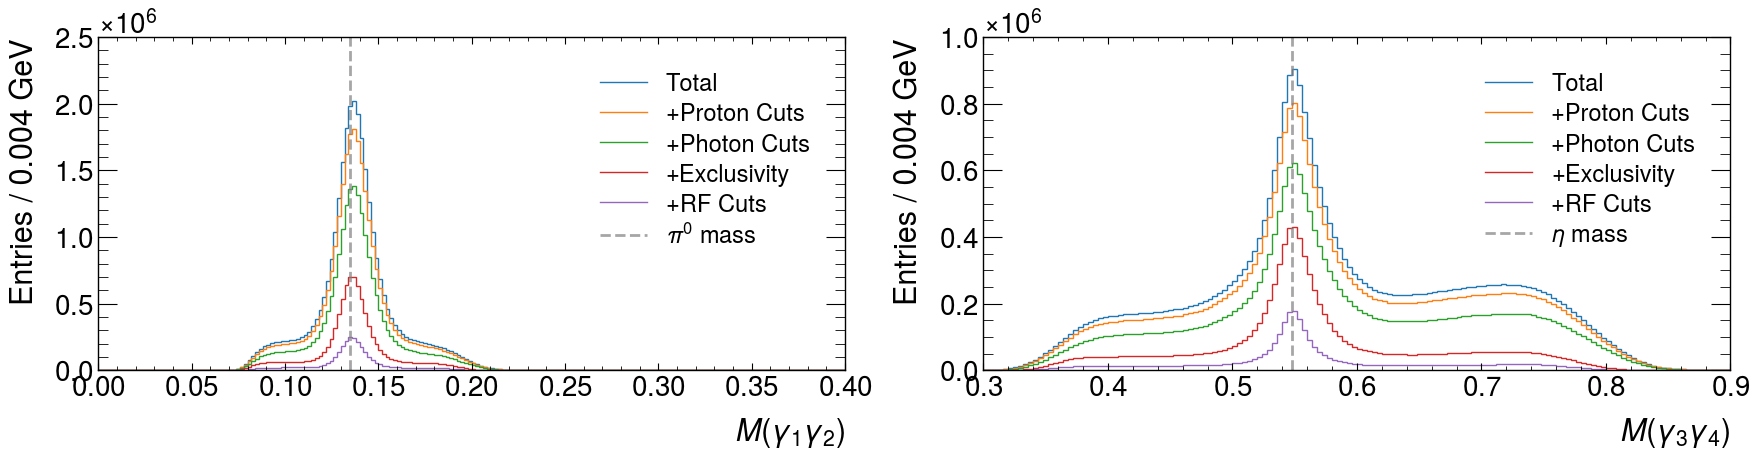

In [65]:
def plotDiagnostic2(df,axes,weights,**kwargs):
    makePlot(df,"Mpi0",0,0.4,0.002,r"$M(\gamma_1\gamma_2)$",axes[0],weights,**kwargs)
    axes[0].set_ylabel("Entries / %0.3f GeV" % (0.004))
    
    makePlot(df,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$",axes[1],weights,**kwargs)
    axes[1].set_ylabel("Entries / %0.3f GeV" % (0.004))

fig,axes=plt.subplots(1,2,figsize=(18,5))

weights1=[1]*len(df1Phase2)
weights2=[1]*len(df2Phase2)
weights3=[1]*len(df3Phase2)
weights4=[1]*len(df4Phase2)
weights5=df5Phase2.AccWeight

# weights1=df1.AccWeight
# weights2=df2.AccWeight
# weights3=df3.AccWeight
# weights4=df4.AccWeight

weights=[weights1,weights2,weights3,weights4,weights5]
dfs=[df1Phase2,df2Phase2,df3Phase2,df4Phase2,df5Phase2]
titles=["Total","+Proton Cuts","+Photon Cuts","+Exclusivity","+RF Cuts"]
for label, df, weight in zip(titles,dfs,weights):
    plotDiagnostic2(df,axes,weight,label=label)

axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[0].legend()
axes[1].legend()
# axes[0].set_yscale("log")
# axes[1].set_yscale("log")
plt.tight_layout()
plt.savefig(resultsFolder+"/mass_distributions_per_cut.pdf")

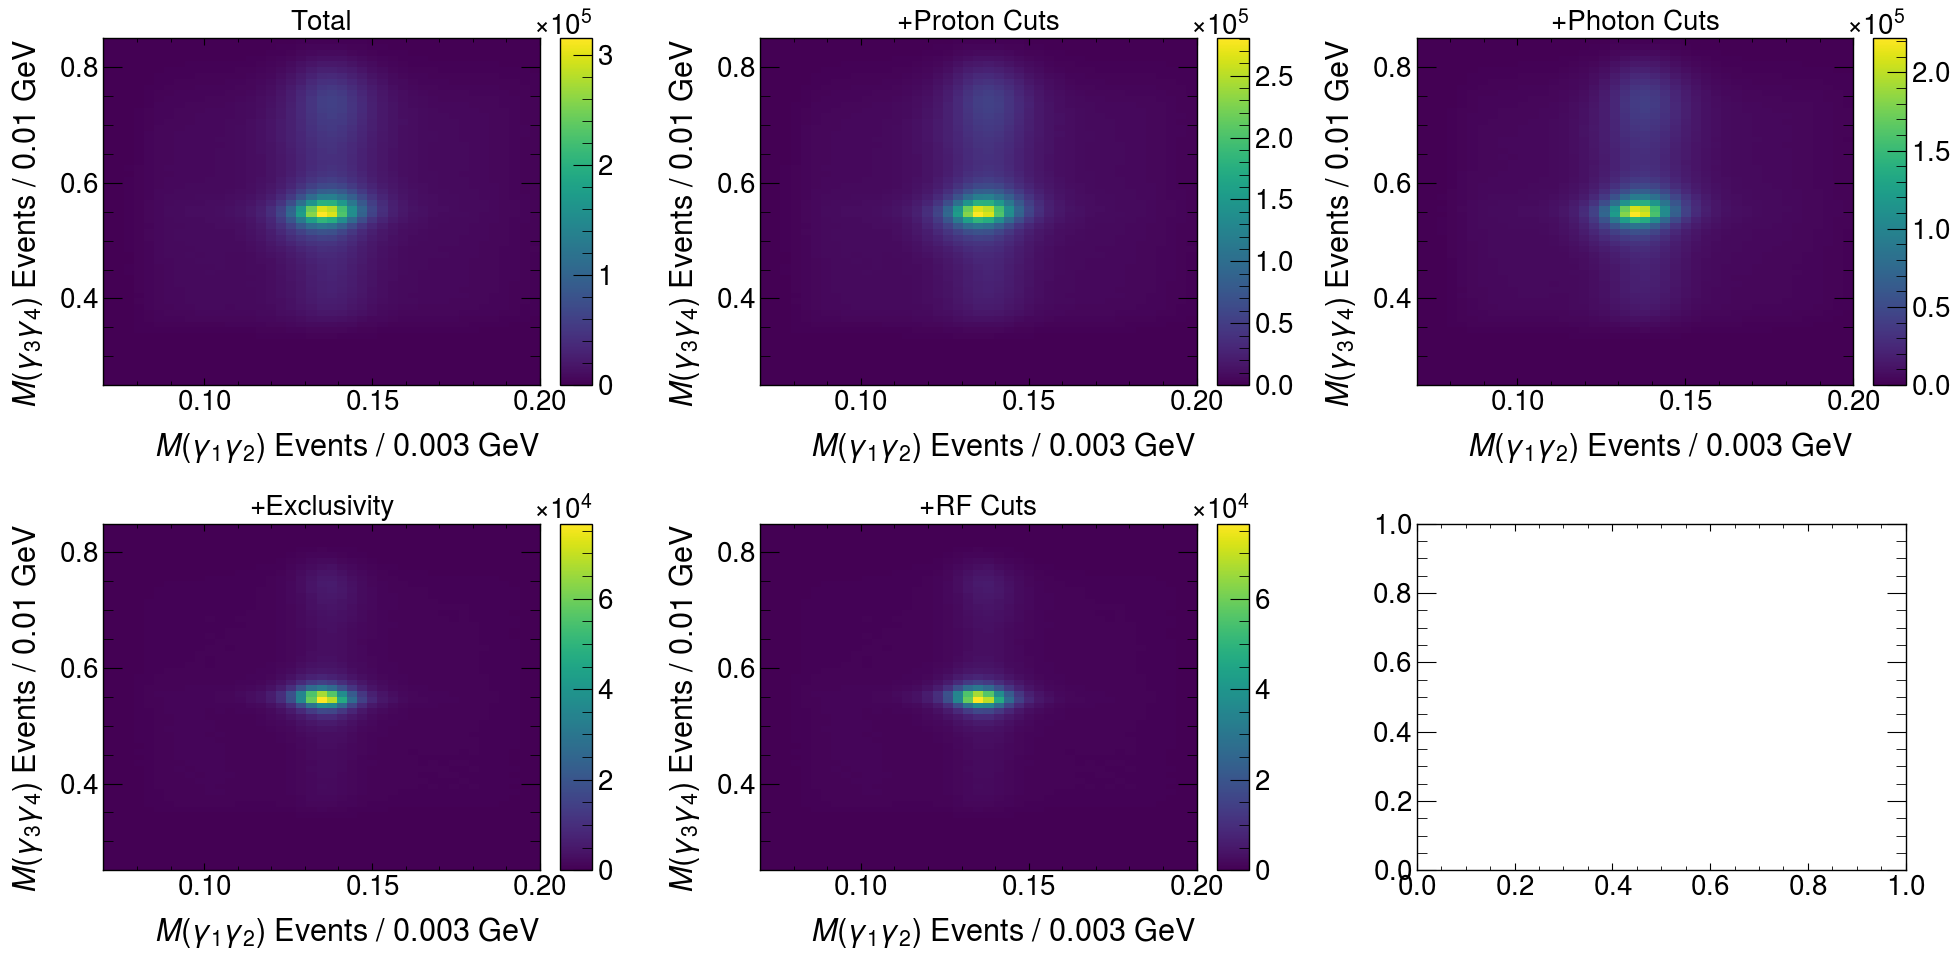

In [67]:
fig,axes=plt.subplots(2,3,figsize=(20,10))
axes=axes.flatten()

doWeight=True

for idf, title,df in zip(range(len(dfs)),titles,dfs):
    if doWeight:
        hep.hist2dplot(np.histogram2d(df.Mpi0,df.Meta,weights=df.AccWeight,
                                      bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[idf],linewidth=0,rasterized=True)
    else:
        hep.hist2dplot(np.histogram2d(df.Mpi0,df.Meta,
                                      bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[idf],linewidth=0,rasterized=True)
    axes[idf].set_xlim(0.07,0.2)
    axes[idf].set_ylim(0.25,0.85)
    axes[idf].set_xlabel("$M(\gamma_1\gamma_2)$ Events / 0.003 GeV")
    axes[idf].set_ylabel("$M(\gamma_3\gamma_4)$ Events / 0.01 GeV")
    axes[idf].set_title(title)
plt.tight_layout()
plt.savefig(resultsFolder+"/mass_distributions_2d_per_cut.pdf")

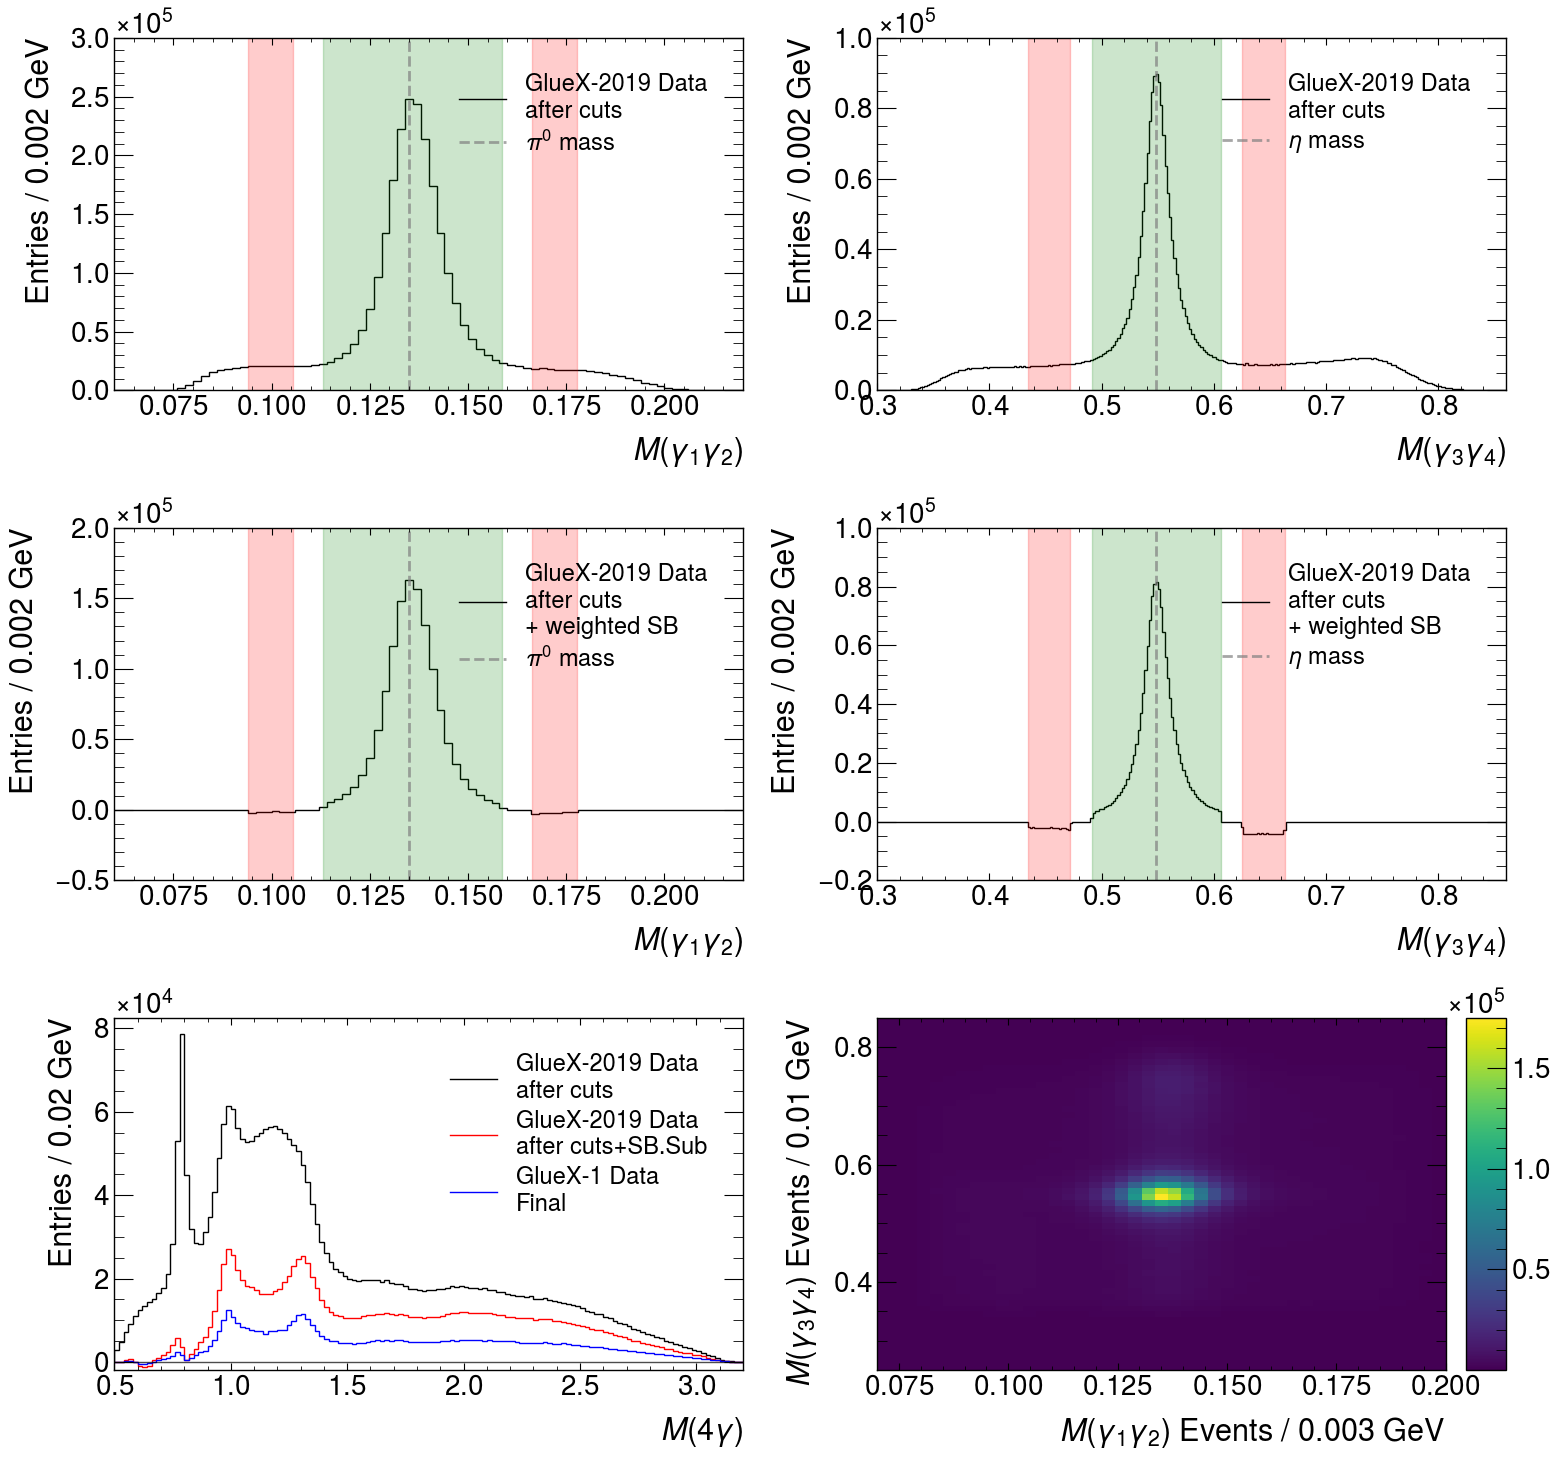

In [68]:
## sidebands
pi0Mean=0.135881
etaMean=0.548625
pi0Std=0.0076
etaStd=0.0191
pi0Sig=3
pi0Skip=1
pi0SB=1.5
etaSig=3
etaSkip=1
etaSB=2

fig,axes=plt.subplots(3,2,figsize=(16,15))
axes=axes.flatten()

mrange=(0.06,0.22)
mstep=0.002
makePlot(df5Phase2,"Mpi0",*mrange,mstep,r"$M(\gamma_1\gamma_2)$",axes[0],df5Phase2["AccWeight"],color='black',label="GlueX-2019 Data\nafter cuts")
axes[0].axvline(pi0mass,color="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[0].set_ylim(bottom=0)
axes[0].legend(loc=1)
axes[0].axvspan(pi0Mean+(pi0Sig+pi0Skip)*pi0Std,pi0Mean+(pi0Sig+pi0Skip+pi0SB)*pi0Std,color='red',alpha=0.2,label='sidebands')
axes[0].axvspan(pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std,pi0Mean-(pi0Sig+pi0Skip)*pi0Std,color='red',alpha=0.2)
axes[0].axvspan(pi0Mean-pi0Sig*pi0Std,pi0Mean+pi0Sig*pi0Std,color='green',alpha=0.2,label='signal')

mrange=(0.3,0.86)
mstep=0.002
makePlot(df5Phase2,"Meta",*mrange,mstep,r"$M(\gamma_3\gamma_4)$",axes[1],df5Phase2["AccWeight"],color='black',label="GlueX-2019 Data\nafter cuts")
axes[1].axvline(etamass,color="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[1].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[1].set_ylim(bottom=0)
axes[1].legend(loc=1)
axes[1].axvspan(etaMean+(etaSig+etaSkip)*etaStd,etaMean+(etaSig+etaSkip+etaSB)*etaStd,color='red',alpha=0.2,label='sidebands')
axes[1].axvspan(etaMean-(etaSig+etaSkip+etaSB)*etaStd,etaMean-(etaSig+etaSkip)*etaStd,color='red',alpha=0.2)
axes[1].axvspan(etaMean-etaSig*etaStd,etaMean+etaSig*etaStd,color='green',alpha=0.2,label='signal')

mrange=(0.06,0.22)
mstep=0.002
makePlot(df5Phase2,"Mpi0",*mrange,mstep,r"$M(\gamma_1\gamma_2)$",axes[2],df5Phase2["weightASBS"],color='black',label="GlueX-2019 Data\nafter cuts \n+ weighted SB")
axes[2].axvline(pi0mass,color="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[2].set_ylabel("Entries / %0.3f GeV" % (mstep))
# axes[2].set_ylim(bottom=0)
axes[2].legend(loc=1)
axes[2].axvspan(pi0Mean+(pi0Sig+pi0Skip)*pi0Std,pi0Mean+(pi0Sig+pi0Skip+pi0SB)*pi0Std,color='red',alpha=0.2,label='sidebands')
axes[2].axvspan(pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std,pi0Mean-(pi0Sig+pi0Skip)*pi0Std,color='red',alpha=0.2)
axes[2].axvspan(pi0Mean-pi0Sig*pi0Std,pi0Mean+pi0Sig*pi0Std,color='green',alpha=0.2,label='signal')

mrange=(0.3,0.86)
mstep=0.002
makePlot(df5Phase2,"Meta",*mrange,mstep,r"$M(\gamma_3\gamma_4)$",axes[3],df5Phase2["weightASBS"],color='black',label="GlueX-2019 Data\nafter cuts \n+ weighted SB")
axes[3].axvline(etamass,color="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[3].set_ylabel("Entries / %0.3f GeV" % (mstep))
# axes[3].set_ylim(bottom=0)
axes[3].legend(loc=1)
axes[3].axvspan(etaMean+(etaSig+etaSkip)*etaStd,etaMean+(etaSig+etaSkip+etaSB)*etaStd,color='red',alpha=0.2,label='sidebands')
axes[3].axvspan(etaMean-(etaSig+etaSkip+etaSB)*etaStd,etaMean-(etaSig+etaSkip)*etaStd,color='red',alpha=0.2)
axes[3].axvspan(etaMean-etaSig*etaStd,etaMean+etaSig*etaStd,color='green',alpha=0.2,label='signal')

mrange=(0.5,3.2)
mstep=0.02
count_edges=makePlot(df5Phase2,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[4],df5Phase2["AccWeight"],color='black',label="GlueX-2019 Data\nafter cuts")
_=makePlot(df5Phase2,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[4],df5Phase2["weightASBS"],color='red',label="GlueX-2019 Data\nafter cuts+SB.Sub")
__=makePlot(df1Phase1,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[4],df1Phase1["weightASBS"],color='blue',label="GlueX-1 Data\nFinal")
# _=makePlot(df5Phase2[~df5Phase2.omegaCut],"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],df5Phase2[~df5Phase2.omegaCut]["weightASBS"],c='red',label="Phase 1 Data\nAcc.Sub. + SB.Sub\n+ LMAC cut")
axes[4].set_ylabel("Entries / %0.2f GeV" % (mstep))
axes[4].set_ylim(bottom=-2000,top=max(count_edges[0])*1.05)
axes[4].axhline(0,color='black',linewidth=1,alpha=0.7)
axes[4].legend()

hep.hist2dplot(np.histogram2d(df5Phase2.Mpi0,df5Phase2.Meta,bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[5],linewidth=0,rasterized=True,
               vmin=0.0001)#,norm=mpl.colors.LogNorm())
axes[5].set_xlim(0.07,0.2)
axes[5].set_ylim(0.25,0.85)
axes[5].set_xlabel("$M(\gamma_1\gamma_2)$ Events / 0.003 GeV")
axes[5].set_ylabel("$M(\gamma_3\gamma_4)$ Events / 0.01 GeV")

plt.tight_layout()
plt.savefig(resultsFolder+"/mass_distributions_sidebands_lmac.pdf")

## Most background in $\gamma_3\gamma_4$ - fit $M(\gamma_3\gamma_4)$ to get purity

In [ ]:
dfs_looseChi=[]
# datasets=["2017_1","2018_1","2018_8"]
# for dataset in datasets:
# #     fileName="/d/grid17/ln16/myDSelector/zThesisCuts/degALL_data_"+dataset+"_stdProtonPhotonExclusivity_looseChi_for_thesis_treeFlat_DSelector.root"
#     fileName="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/looseUE/D"+dataset+"_selected_acc_flat.root"
#     treeName="kin"
#     cols=["Mpi0eta","weightASBS","weightBS","cosTheta_eta_gj","cosTheta_eta_hel","phi_eta_gj","phi_eta_hel",
#           "Mpi0","Meta","AccWeight","chiSq","Ebeam","mandelstam_t","mandelstam_tp","Mpi0p","Metap","omegaCut","unusedEnergy",
#          "mandelstam_teta","mandelstam_tpi0","run","event","rfTime","phi_eta_lab","phi_pi0_lab","BeamAngle"]
#     tree=uproot.open(fileName)[treeName]
# #     df=tree.arrays(cols,entrystart=0,entrystop=100000,outputtype=pd.DataFrame).reset_index(drop=True)
#     df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
#     dfs_looseChi.append(df)
    
# yields=[dfs_looseChi[i].weightASBS.sum() for i in range(len(dfs_looseChi))]
# yieldsFrac=[val/sum(yields) for val in yields]
# for i,val in enumerate(yieldsFrac):
#     print(datasets[i]+" integral: %0.2f" % val)

datasets=["2019"]
for dataset in datasets:
#     fileName="/d/grid17/ln16/myDSelector/zThesisCuts/degALL_data_"+dataset+"_stdProtonPhotonExclusivity_looseChi_for_thesis_treeFlat_DSelector.root"
    fileName="/d/home/septian/EtaPi0Analysis/testNewData_acc_acc_flat.root"
    treeName="kin"
    cols=["Mpi0eta","weightASBS","weightBS","cosTheta_eta_gj","cosTheta_eta_hel","phi_eta_gj","phi_eta_hel",
          "Mpi0","Meta","AccWeight","chiSq","Ebeam","mandelstam_t","mandelstam_tp","Mpi0p","Metap","omegaCut","unusedEnergy",
         "mandelstam_teta","mandelstam_tpi0","run","event","rfTime","phi_eta_lab","phi_pi0_lab","BeamAngle"]
    tree=uproot.open(fileName)[treeName]
#     df=tree.arrays(cols,entrystart=0,entrystop=100000,outputtype=pd.DataFrame).reset_index(drop=True)
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    dfs_looseChi.append(df)
    
yields=[dfs_looseChi[i].weightASBS.sum() for i in range(len(dfs_looseChi))]
print("yields,sum(yields) =",yields,sum(yields))
yieldsFrac=[val/sum(yields) for val in yields]
for i,val in enumerate(yieldsFrac):
    print(datasets[i]+" integral: %0.2f" % val)


In [ ]:
dfs_looseChi[0].head()

In [ ]:
# phase1_looseChi=pd.concat(dfs_looseChi)
data_2019_looseChi=pd.concat(dfs_looseChi)
# phase1_looseChi=phase1_looseChi.sample(4000000)

In [ ]:
# tmp=data_2019_looseChi#.sample(5000000)
# tmp=tmp[tmp.chiSq<13.277]
# tmp=tmp[~tmp.omegaCut]
tmp=df4

In [ ]:
## sidebands
pi0Mean=0.135881
etaMean=0.548625
pi0Std=0.0076
etaStd=0.0191
pi0Sig=3
pi0Skip=1
pi0SB=1.5
etaSig=3
etaSkip=1
etaSB=2

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

mrange=(0.06,0.22)
mstep=0.002
makePlot(tmp,"Mpi0",*mrange,mstep,r"$M(\gamma_1\gamma_2)$",axes[0],tmp["AccWeight"],color='black',label="GlueX-2019 Data\nafter cuts")
axes[0].axvline(pi0mass,color="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[0].set_ylim(bottom=0)
axes[0].legend(loc=1)
axes[0].axvspan(pi0Mean+(pi0Sig+pi0Skip)*pi0Std,pi0Mean+(pi0Sig+pi0Skip+pi0SB)*pi0Std,color='red',alpha=0.2,label='sidebands')
axes[0].axvspan(pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std,pi0Mean-(pi0Sig+pi0Skip)*pi0Std,color='red',alpha=0.2)
axes[0].axvspan(pi0Mean-pi0Sig*pi0Std,pi0Mean+pi0Sig*pi0Std,color='green',alpha=0.2,label='signal')

mrange=(0.3,0.86)
mstep=0.002
makePlot(tmp,"Meta",*mrange,mstep,r"$M(\gamma_3\gamma_4)$",axes[1],tmp["AccWeight"],color='black',label="GlueX-2019 Data\nafter cuts")
axes[1].axvline(etamass,color="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[1].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[1].set_ylim(bottom=0)
axes[1].legend(loc=1)
axes[1].axvspan(etaMean+(etaSig+etaSkip)*etaStd,etaMean+(etaSig+etaSkip+etaSB)*etaStd,color='red',alpha=0.2,label='sidebands')
axes[1].axvspan(etaMean-(etaSig+etaSkip+etaSB)*etaStd,etaMean-(etaSig+etaSkip)*etaStd,color='red',alpha=0.2)
axes[1].axvspan(etaMean-etaSig*etaStd,etaMean+etaSig*etaStd,color='green',alpha=0.2,label='signal')

mrange=(0.5,3.2)
mstep=0.02
count_edges=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp["AccWeight"],color='black',label="GlueX-2019 Data\nafter cuts")
_=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp["weightASBS"],color='red',label="GlueX-2019 Data\nafter cuts+SB.Sub")
# _=makePlot(tmp[~tmp.omegaCut],"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp[~tmp.omegaCut]["weightASBS"],c='red',label="Phase 1 Data\nAcc.Sub. + SB.Sub\n+ LMAC cut")
axes[2].set_ylabel("Entries / %0.2f GeV" % (mstep))
axes[2].set_ylim(bottom=-2000,top=max(count_edges[0])*1.05)
axes[2].axhline(0,color='black',linewidth=1,alpha=0.7)
axes[2].legend()

hep.hist2dplot(np.histogram2d(tmp.Mpi0,tmp.Meta,bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[3],linewidth=0,rasterized=True,
               vmin=0.0001)#,norm=mpl.colors.LogNorm())
axes[3].set_xlim(0.07,0.2)
axes[3].set_ylim(0.25,0.85)
axes[3].set_xlabel("$M(\gamma_1\gamma_2)$ Events / 0.003 GeV")
axes[3].set_ylabel("$M(\gamma_3\gamma_4)$ Events / 0.01 GeV")

plt.tight_layout()
plt.savefig(resultsFolder+"/mass_distributions_sidebands_lmac.pdf")

In [ ]:
## sidebands
pi0Mean=0.135881
etaMean=0.548625
pi0Std=0.0076
etaStd=0.0191
pi0Sig=3
pi0Skip=1
pi0SB=1.5
etaSig=3
etaSkip=1
etaSB=2

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

mrange=(0.06,0.22)
mstep=0.002
makePlot(tmp,"Mpi0",*mrange,mstep,r"$M(\gamma_1\gamma_2)$",axes[0],tmp["AccWeight"],color='black',label="Phase 1 Data\nAccidental Subtracted")
axes[0].axvline(pi0mass,color="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[0].set_ylim(bottom=0)
axes[0].legend(loc=1)
axes[0].axvspan(pi0Mean+(pi0Sig+pi0Skip)*pi0Std,pi0Mean+(pi0Sig+pi0Skip+pi0SB)*pi0Std,color='red',alpha=0.2,label='sidebands')
axes[0].axvspan(pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std,pi0Mean-(pi0Sig+pi0Skip)*pi0Std,color='red',alpha=0.2)
axes[0].axvspan(pi0Mean-pi0Sig*pi0Std,pi0Mean+pi0Sig*pi0Std,color='green',alpha=0.2,label='signal')

mrange=(0.3,0.86)
mstep=0.002
makePlot(tmp,"Meta",*mrange,mstep,r"$M(\gamma_3\gamma_4)$",axes[1],tmp["AccWeight"],color='black',label="Phase 1 Data\nAccidental Subtracted")
axes[1].axvline(etamass,color="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[1].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[1].set_ylim(bottom=0)
axes[1].legend(loc=1)
axes[1].axvspan(etaMean+(etaSig+etaSkip)*etaStd,etaMean+(etaSig+etaSkip+etaSB)*etaStd,color='red',alpha=0.2,label='sidebands')
axes[1].axvspan(etaMean-(etaSig+etaSkip+etaSB)*etaStd,etaMean-(etaSig+etaSkip)*etaStd,color='red',alpha=0.2)
axes[1].axvspan(etaMean-etaSig*etaStd,etaMean+etaSig*etaStd,color='green',alpha=0.2,label='signal')

mrange=(0.5,3.2)
mstep=0.02
count_edges=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp["AccWeight"],color='black',label="Phase 1 Data\nAccidental Subtracted")
_=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp["weightASBS"],color='red',label="Phase 1 Data\nAcc.Sub.+SB.Sub")
# _=makePlot(tmp[~tmp.omegaCut],"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp[~tmp.omegaCut]["weightASBS"],c='red',label="Phase 1 Data\nAcc.Sub. + SB.Sub\n+ LMAC cut")
axes[2].set_ylabel("Entries / %0.2f GeV" % (mstep))
axes[2].set_ylim(bottom=-2000,top=max(count_edges[0])*1.05)
axes[2].axhline(0,color='black',linewidth=1,alpha=0.7)
axes[2].legend()

hep.hist2dplot(np.histogram2d(df.Mpi0,df.Meta,bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[3],linewidth=0,rasterized=True,
               vmin=0.0001)#,norm=mpl.colors.LogNorm())
axes[3].set_xlim(0.07,0.2)
axes[3].set_ylim(0.25,0.85)
axes[3].set_xlabel("$M(\gamma_1\gamma_2)$ Events / 0.003 GeV")
axes[3].set_ylabel("$M(\gamma_3\gamma_4)$ Events / 0.01 GeV")

plt.tight_layout()
plt.savefig(resultsFolder+"/mass_distributions_sidebands_lmac.pdf")

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(16,10))
# axes=axes.flatten()
count_edges=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[0],tmp["AccWeight"],color='black',label="Phase 1 Data\nAccidental Subtracted")
_=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[0],tmp["weightASBS"],color='red',label="Phase 1 Data\nAcc.Sub.+SB.Sub")
# _=makePlot(tmp[~tmp.omegaCut],"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp[~tmp.omegaCut]["weightASBS"],c='red',label="Phase 1 Data\nAcc.Sub. + SB.Sub\n+ LMAC cut")
axes[0].set_ylabel("Entries / %0.2f GeV" % (mstep))
axes[0].set_ylim(bottom=-2000,top=max(count_edges[0])*1.05)
axes[0].axhline(0,color='black',linewidth=1,alpha=0.7)
axes[0].legend()
count_edgesOld=makePlot(df4Old,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[1],tmp["AccWeight"],color='black',label="Phase 1 Data\nAccidental Subtracted")
_Old=makePlot(df4Old,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[1],tmp["weightASBS"],color='red',label="Phase 1 Data\nAcc.Sub.+SB.Sub")
# _=makePlot(tmp[~tmp.omegaCut],"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp[~tmp.omegaCut]["weightASBS"],c='red',label="Phase 1 Data\nAcc.Sub. + SB.Sub\n+ LMAC cut")
axes[1].set_ylabel("Entries / %0.2f GeV" % (mstep))
axes[1].set_ylim(bottom=-2000,top=max(count_edges[0])*1.05)
axes[1].axhline(0,color='black',linewidth=1,alpha=0.7)
axes[1].legend()

In [ ]:
def addText(value, string, counts, edges, ax):
    ''' Add string above the value that is located in a bin defined by edges'''
    count=counts[np.where(value<edges)[0][0]]
    ax.text(x=value, y=count*1.2, s=string, size=20)

In [ ]:
####################
# BARYON PLOTS
####################

tmp=tmp[tmp.omegaCut]

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()
fig.delaxes(axes[3])

makePlot(tmp,"mandelstam_t",0,3,0.03,r"$-t~(GeV^2)$",axes[0],tmp["weightASBS"],color='black',label="Phase 1 Data")
makePlot(tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.8)],"mandelstam_t",0,3,0.03,r"$-t~(GeV^2)$",axes[0],
         tmp.loc[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.8),"weightASBS"],color='red',
         label="-t$\in$[0.1,1.0]\n$M(\eta\pi)$ $\in$[1.04,1.80]")
makePlot(tmp[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.80)],"mandelstam_t",0,3,0.03,r"$-t~(GeV^2)$",axes[0],
         tmp.loc[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.80),"weightASBS"],color='royalblue',
         label="$M(\eta\pi)$ $\in$[1.6,1.8]")
axes[0].set_ylabel("Entries / %0.3f GeV" % (0.03))
axes[0].set_ylim(bottom=0)
axes[0].legend(prop={"size":20})

counts, edges=makePlot(tmp,"Mpi0p",1.0,4.0,0.02,r"$M(\pi^0 p)$ GeV",axes[1],tmp["weightASBS"],color='black',label="Phase 1 Data")
makePlot(tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.8)],"Mpi0p",1.0,4.0,0.02,r"$M(\pi^0 p)$ GeV",axes[1],
         tmp.loc[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.8),"weightASBS"],color='red')
makePlot(tmp[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8)],"Mpi0p",1.0,4.0,0.02,r"$M(\pi^0 p)$ GeV",axes[1],
         tmp.loc[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8),"weightASBS"],color='royalblue')
axes[1].set_ylabel("Entries / %0.3f GeV" % (0.02))
axes[1].set_ylim(bottom=0)
addText(1.232,r"$\Delta^+(1232)$",counts, edges, axes[1])
# axes[1].legend()

counts, edges=makePlot(tmp,"Metap",1.4,4.5,0.02,r"$M(\eta p)$ GeV",axes[2],tmp["weightASBS"],color='black',label="Phase 1 Data")
makePlot(tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.8)],"Metap",1.4,4.5,0.02,r"$M(\eta p)$ GeV",axes[2],
         tmp.loc[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.8),"weightASBS"],color='red')
makePlot(tmp[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8)],"Metap",1.4,4.5,0.02,r"$M(\eta p)$ GeV",axes[2],
         tmp.loc[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8),"weightASBS"],color='royalblue')
axes[2].set_ylabel("Entries / %0.3f GeV" % (0.02))
axes[2].set_ylim(bottom=0)
addText(1.535,r"$N(1535)$",counts, edges, axes[2])
# axes[2].legend(bbox_to_anchor=(1.1,1),prop={"size":24})


plt.tight_layout()
plt.savefig(resultsFolder+"/baryon_plots.pdf")

In [ ]:
# tmp=phase1_looseChi
# tmp=tmp[tmp.chiSq<13.277]
# tmp=tmp[~tmp.omegaCut]
# tmp=tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)]
# tmp=tmp[(tmp.Mpi0p>1.4)]

fig,axes=plt.subplots(2,2,figsize=(16,12))
axes=axes.flatten()

mrange=(0.6,3.2)
mstep=0.02
makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(\eta\pi)$ GeV",axes[2],tmp["weightASBS"],color='black',label="Phase 1 Data")
axes[2].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[2].set_ylim(bottom=0)
axes[2].set_xlim(*mrange)


def getFrac(m,mrange):
    l,u=mrange
    return (m-l)/(u-l)
######################################
### annotate a2 region ###
axes[2].annotate("",
            xy=(getFrac(1.04,mrange),0.89), xycoords='axes fraction',
            xytext=(getFrac(1.8,mrange), 0.89), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3", color='royalblue', lw=2)
            )
axes[2].text(getFrac(1.2,mrange), 0.91, r'$a_2$ analysis',fontsize = 18,transform=axes[2].transAxes,color='royalblue')
######################################
### annotate DREx region ###
axes[2].annotate("",
            xy=(getFrac(1.6,mrange),0.75), xycoords='axes fraction',
            xytext=(getFrac(3.0,mrange), 0.75), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3", color='r', lw=2)
            )
axes[2].text(getFrac(2.0,mrange), 0.77, 'DREx analysis',fontsize = 18,transform=axes[2].transAxes,color='red')
######################################
# axes[2].axvspan(1.04,1.80,color='royalblue',alpha=0.4,label=r"$a_2$ analysis")
# axes[2].axvspan(1.60,3.0,color='orange',alpha=0.4,label=r"DREx analysis")
axes[2].legend(prop={"size":20})


hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.cosTheta_eta_gj,weights=tmp.weightASBS,
                              bins=(getBinning(*mrange,mstep),getBinning(-1,1,0.02))),ax=axes[0],linewidth=0,rasterized=True,
               vmin=0.0001)
axes[0].set_xlim(*mrange)
axes[0].set_ylim(-1,1)
axes[0].set_xlabel(f"$M(4\gamma)$ Events / {mstep} GeV")
axes[0].set_ylabel(r"$cos\theta_{GJ}$ Events / 0.02")

plt.tight_layout()

hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,weights=tmp.weightASBS,
                              bins=(getBinning(*mrange,mstep),getBinning(-1,1,0.02))),ax=axes[1],linewidth=0,rasterized=True,
               vmin=0.0001)
axes[1].set_xlim(*mrange)
axes[1].set_ylim(-1,1)
axes[1].set_xlabel(f"$M(4\gamma)$ Events / {mstep} GeV")
axes[1].set_ylabel(r"$cos\theta_{hel}$ Events / 0.02")

axes[3].axis(False)

plt.tight_layout()

plt.savefig(resultsFolder+"/final_M4g_and_cosM4g.pdf")

## Segue to Combinatorics in Data to introduce accidental subtraction
### Since there could be correlations between beam photon combinatorics and the chiSq threshold selection

In [ ]:
phase1_looseChi=phase1_looseChi[(phase1_looseChi.Ebeam>8.2)&(phase1_looseChi.Ebeam<8.8)]

In [ ]:
phase1_looseChi["kindOfUniqueID"]=phase1_looseChi["run"].astype(str)+"_"+phase1_looseChi["event"].astype(str)

In [ ]:
plt.figure(figsize=(8,5))
comboCount=phase1_looseChi.kindOfUniqueID.value_counts().values
hComboCount=np.histogram(comboCount,bins=getBinning(comboCount.min(),comboCount.max(),1))
hep.histplot(hComboCount,color='black')
plt.xlim(comboCount.min(),comboCount.max())
plt.yscale("log")
plt.xlabel("Combos Per Event")
plt.ylabel("Entries / 1 Combo Per Event")

ax=plt.twinx()
cdfx=range(1,int(hComboCount[1][-1]))
cdfy=[sum(hComboCount[0][hComboCount[1][:-1]<=i]) for i in cdfx]
cdfy=cdfy/cdfy[-1]
plt.plot(cdfx,cdfy,marker='.',c='indianred')
ax.spines["right"].set_edgecolor('indianred')
ax.tick_params(axis='y', colors='indianred')
ax.set_ylabel(r"P(X$\leq$x)",size=28,c='indianred')
ax.set_ylim(bottom=0)

In [ ]:
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]

makePlot(tmp,"rfTime",-24,24,0.2,"RF Time (ns)",axes[0],[1]*len(tmp),color='black',alpha=1,label="Data")
axes[0].axvspan(-2,2,label="Signal",linewidth=2,color='green',alpha=0.2)
axes[0].axvspan(6,18,label="Sideband",linewidth=2,color='red',alpha=0.2)
axes[0].axvspan(-18,-6,color='red',linewidth=2,alpha=0.2)
axes[0].set_ylabel("Entries / %0.2f ns" % (0.2))
axes[0].legend(bbox_to_anchor=(0.45,0.9))#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+"/rf_time_subtraction.pdf")

# Extract significance metrics

In [ ]:
def poly(x, a, b, c):
    return a+b*x+c*x**2

def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def doublegaussian(x, A, B, mu, sig, sig2):
    return gaussian(x,A,mu,sig)+gaussian(x,B,mu,sig2)
    #return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + B*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig2, 2.)))

def fit(x, A, B, mu, sig, sig2, a, b, c):
    return doublegaussian(x,A,B,mu,sig,sig2)+poly(x,a,b,c)
# def fit(x, A, mu, sig, a, b, c):
#     return gaussian(x,A,mu,sig)+poly(x,a,b,c)

In [ ]:
def extractSignificance(df,weight,binning,chiSqThresholds,axes,iax,region):    
    out=np.histogram(df["Meta"],weights=weight,bins=binning)
    ax=axes[iax]
    width=out[1][1]-out[1][0]
    centers=out[1][:-1]+(out[1][1]-out[1][0])/2
    hep.histplot(out,color='gray',label="Data",ax=ax)

    minrange=0.4
    if region==0:
        #### ACCIDENTAL SUBTRACTION
        constTerms=np.linspace(5000,2000,len(chiSqThresholds)) # np.linspace(10000,100,len(chiSqThresholds))
        ampTerms=np.linspace(10000,10000,len(chiSqThresholds))
        maxrange=0.75
    elif region==1:
        #### ACCIDENTAL SUBTRACTION AND 1.04<MPI0ETA<1.8
        constTerms=np.linspace(2500,2000,len(chiSqThresholds)) # np.linspace(10000,100,len(chiSqThresholds))
        ampTerms=np.linspace(5000,8000,len(chiSqThresholds))
        maxrange=0.75
    elif region==2:
        #### ACCIDENTAL SUBTRACTION AND MPI0ETA>1.6 but <2.8
        constTerms=np.linspace(2500,500,len(chiSqThresholds)) # np.linspace(10000,100,len(chiSqThresholds))
        ampTerms=np.linspace(5000,2000,len(chiSqThresholds))
        maxrange=0.74

    yields_in_region=out[0][(centers>minrange)&(centers<maxrange)]
    centers_in_region=centers[(centers>minrange)&(centers<maxrange)]
    
    try:
        popt, pcov = curve_fit(fit,centers_in_region,yields_in_region,p0=(ampTerms[iax],ampTerms[iax],0.55,0.05,0.05,constTerms[iax],0,0))
        #print(popt)
        ax.plot(centers_in_region,fit(centers_in_region, *popt),color='steelblue',label="Gaus+Poly")
        ax.plot(centers_in_region,poly(centers_in_region, *popt[5:]),color='red',linestyle='--',label="Poly")
        ax.plot(centers_in_region,doublegaussian(centers_in_region, *popt[:5]),color='green',linestyle='--',label="Gaus")
        
        sig_yield1=quad(gaussian, popt[2]-3*abs(popt[3]), popt[2]+3*abs(popt[3]), args=(popt[0],popt[2],popt[3]))[0]
        sig_yield2=quad(gaussian, popt[2]-3*abs(popt[4]), popt[2]+3*abs(popt[4]), args=(popt[1],popt[2],popt[4]))[0]
        weightedSigma = sig_yield1/(sig_yield1+sig_yield2)*abs(popt[3])+sig_yield2/(sig_yield1+sig_yield2)*abs(popt[4])
        integral_minrange=popt[2]-3*abs(weightedSigma)
        integral_maxrange=popt[2]+3*abs(weightedSigma)
        ax.axvline(integral_minrange,c='orange',linestyle='dotted')
        ax.axvline(integral_maxrange,c='orange',linestyle='dotted')
        bkg_yield=quad(poly, integral_minrange, integral_maxrange, args=tuple(popt[5:]))[0]
        sig_yield=quad(doublegaussian, integral_minrange, integral_maxrange, args=tuple(popt[:5]))[0]
        tot_yield=quad(fit, integral_minrange, integral_maxrange, args=tuple(popt))[0]
        bkg_yield/=width
        sig_yield/=width
        tot_yield/=width
        purity=sig_yield/(sig_yield+bkg_yield)
        significance_sb=sig_yield/np.sqrt(sig_yield+bkg_yield)
        significance_b=sig_yield/np.sqrt(bkg_yield)
        significance_sbb=2*(np.sqrt(sig_yield+bkg_yield)-np.sqrt(bkg_yield))
        significance_cl=np.sqrt(2*(sig_yield+bkg_yield)*np.log(1+sig_yield/bkg_yield)-2*sig_yield)
        ax.text(0.05,0.35,"Within 3$\sigma$\n--------------\nSignal Yield: %0.0fk\nBkg Yield:%0.0fk\nPurity: %0.2f\ns/sqrt(s+b): %0.0f\ns/sqrt(b): %0.0f" % (sig_yield/1000,bkg_yield/1000,
                                                                                                                                 purity,significance_sb,significance_b),size=14,transform=ax.transAxes)
    except:
        print("One iteration failed")
        return 0,0,0,0,0,0,0
    ax.set_title("$\chi^2$ < %0.2f"%chiSqThresholds[iax])
    ax.legend(prop={"size":14},loc=1)
    ax.set_ylim(bottom=0)
    if iax in [15,16,17,18]:
        ax.set_xlabel("$M(\gamma_3\gamma_4)$")
    if iax in [0,4,8,12,16,20]:
        ax.set_ylabel("Events / %0.3f GeV" % width)
    return sig_yield, bkg_yield, purity, significance_sb, significance_b, significance_sbb, significance_cl
    
    
    
def makeYieldFits(region,chiSqThresholds):
    fig,axes=plt.subplots(5,4,figsize=(22,20),sharex=True)
    axes=axes.flatten()
    
    ########################
    # Apply any cuts to phase1_looseChi for testing purposes. i.e. if you want to compare the significance plots in the resonance vs the DR region
    ########################
    if region==0:
        phase1_looseChi_copy=phase1_looseChi[(phase1_looseChi.Mpi0p>1.4)]
    elif region==1:
        phase1_looseChi_copy=phase1_looseChi[
            (phase1_looseChi.Mpi0eta>1.04)&(phase1_looseChi.Mpi0eta<1.8)
            &(phase1_looseChi.Mpi0p>1.4)
#             &(phase1_looseChi.mandelstam_t>0.1)&(phase1_looseChi.mandelstam_t<1.0)
                                            ]
    elif region==2:
        phase1_looseChi_copy=phase1_looseChi[(phase1_looseChi.Mpi0eta>1.6)&(phase1_looseChi.Mpi0eta<2.8)
                                            &(phase1_looseChi.Mpi0p>1.4)]

    binning=getBinning(phase1_looseChi_copy["Meta"].min(),phase1_looseChi_copy["Meta"].max()-0.2,0.006)
    sig_yields=[]
    bkg_yields=[]
    puritys=[]
    significances_sb=[]
    significances_b=[]
    significances_sbb=[]
    significances_cl=[]
    for iax, chiSqThreshold in enumerate(chiSqThresholds):
        if chiSqThreshold in chiSqThresholds:#chiSqThresholds:#[-2:]:
            tmp_df=phase1_looseChi_copy[(phase1_looseChi_copy.chiSq<chiSqThreshold)]
            weight=tmp_df.AccWeight        
            sig_yield, bkg_yield, purity, significance_sb, significance_b, significance_sbb, significance_cl = extractSignificance(
                tmp_df,weight,binning,chiSqThresholds,axes,iax,region)
            sig_yields.append(sig_yield)
            bkg_yields.append(bkg_yield)
            puritys.append(purity)
            significances_sb.append(significance_sb)
            significances_b.append(significance_b)
            significances_sbb.append(significance_sbb)
            significances_cl.append(significance_cl)
            
        axes[iax].set_xlim(0.2,0.9)
            
    for iax in range(len(chiSqThresholds),5*4):
        axes[iax].axis(False)
            
    plt.tight_layout()
    
    if region==0:
        plt.savefig(resultsFolder+"/Meta_fits_get_purity_Mpi0etaIntegrated.pdf")
    elif region==1:
        plt.savefig(resultsFolder+"/Meta_fits_get_purity_Mpi0etaGT104LT18.pdf")
    elif region==2:
        plt.savefig(resultsFolder+"/Meta_fits_get_purity_Mpi0etaGT16LT28.pdf")
    
    return (puritys, sig_yields, significances_sb, significances_b, significances_sbb, significances_cl)
    

In [ ]:
def standardize_array(array):
    if type(array)==list:
        array=np.array(array)
    return (array-array.min())/(array.max()-array.min())

def polyH(x, a, b, c, d, e, f, g):
    return a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6

def polyHderiv(x, a, b, c, d, e):
    return b+2*c*x+3*d*x**2+4*e*x**3+5*f*x**4+6*g*x**5

def makeSignificancePlot(region,significances,chiSqThresholds):
    puritys, sig_yields, significances_sb, significances_b, significances_sbb, significances_cl = significances
    fig,axes=plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [1, 2]})

    axes[0].scatter(chiSqThresholds,puritys,color="none", edgecolor="steelblue",linewidth=3)
    axes[0].set_xlabel("$\chi^2$",fontname="stix",size=30)
    axes[0].set_ylim((0,axes[0].get_ylim()[1]*1.1))
    axes[0].set_ylabel(r"$\frac{signal}{signal+bkg}$",size=30,c="steelblue")
    axes[0].tick_params(axis='y', colors='steelblue')

    axes02=axes[0].twinx()
    axes02.scatter(chiSqThresholds,sig_yields,color='indianred',marker='x',linewidth=3)
    axes02.spines["right"].set_edgecolor('indianred')
    axes02.tick_params(axis='y', colors='indianred')
    axes02.set_ylabel(r"Signal Yield",size=24,c='indianred')
    axes02.set_ylim((0,axes02.get_ylim()[1]*1.1))

    NDF=4
    axes[0].axvline(13.277,c='black',linestyle='--',label='selected threshold')

    h1, l1 = axes[0].get_legend_handles_labels()
    h2, l2 = axes02.get_legend_handles_labels()
    axes[0].legend(h2+h1, l2+l1, loc=4)

#     axes[1].scatter(chiSqThresholds,standardize_array(significances_sb),marker='o',alpha=0.8,
#                  s=80,facecolor='steelblue',edgecolor='steelblue',label=r"$\frac{s}{\sqrt{s+b}}$")
#     axes[1].scatter(chiSqThresholds,standardize_array(significances_b),edgecolor='indianred',marker='d',alpha=0.8,
#                  s=80,facecolor='indianred',label=r"$\frac{s}{\sqrt{b}}$")
#     axes[1].scatter(chiSqThresholds,standardize_array(significances_sbb),edgecolor='forestgreen',marker='^',
#                  alpha=0.8,facecolor='forestgreen',s=80,label=r"$2\left(\sqrt{s+b}-\sqrt{b}\ \ \right)$")
    axes[1].scatter(chiSqThresholds,standardize_array(significances_cl),color='forestgreen',s=80,marker='x',
                 alpha=0.8,facecolor='forestgreen',label=r"$\sqrt{2(s+b)ln(1+\frac{s}{b})-2s}$")


    axes[1].axvline(13.277,c='black',linestyle='--',label='p-value=0.01')
    axes[1].set_ylabel("Arbitrary Units")
    axes[1].legend(loc="lower center")
    axes[1].set_xlabel("$\chi^2$",fontname="stix",size=30)

    plt.tight_layout()
    
    if region==0:
        axes[1].set_title(r"Significance Metrics : All $M(\pi^0\eta)$",size=24)
        plt.savefig(resultsFolder+"/significance_vs_chiSqCut_Mpi0etaIntegrated.pdf")
    elif region==1:
        axes[1].set_title(r"Significance Metrics : 1.04 < $M(\pi^0\eta)$ < 1.8 GeV",size=24)
        plt.savefig(resultsFolder+"/significance_vs_chiSqCut_Mpi0etaGT104LT18.pdf")
    elif region==2:
        axes[1].set_title(r"Significance Metrics : 1.60 < $M(\pi^0\eta)$ < 2.8 GeV",size=24)
        plt.savefig(resultsFolder+"/significance_vs_chiSqCut_Mpi0etaGT16LT28.pdf")

In [ ]:
chiSqThresholds=np.arange(3,looseChiSq,2)
significances0=makeYieldFits(0,chiSqThresholds)
significances1=makeYieldFits(1,chiSqThresholds)
significances2=makeYieldFits(2,chiSqThresholds)

In [ ]:
makeSignificancePlot(0,significances0,chiSqThresholds)#[::-1])
makeSignificancePlot(1,significances1,chiSqThresholds)#[::-1])
makeSignificancePlot(2,significances2,chiSqThresholds)#[::-1])

In [ ]:
tmp=phase1_looseChi[
    (phase1_looseChi.Mpi0eta>1.04)&(phase1_looseChi.Mpi0eta<1.80)
    &(phase1_looseChi.mandelstam_t<1.0)&(phase1_looseChi.mandelstam_t>0.1)
    &(phase1_looseChi.chiSq<13.277)
    &(phase1_looseChi.omegaCut)
    &(phase1_looseChi.Mpi0p>1.4)
]

In [ ]:
fig,axes=plt.subplots(3,2,figsize=(16,16))
axes=axes.flatten()
for mint,maxt,ax in zip([0.1,0.2,0.325,0.5,0.75],[0.2,0.325,0.5,0.75,1.0],axes):
    tmp2=tmp[(tmp.mandelstam_t>mint)&(tmp.mandelstam_t<maxt)]
    hep.hist2dplot(np.histogram2d(tmp2.Mpi0eta,tmp2.cosTheta_eta_gj,weights=tmp2.weightASBS,bins=(50,50)),ax=ax)
    ax.set_xlabel(r'$M(\pi\eta)$ GeV')
    ax.set_ylabel(r'$cos\theta_{hel}$')
    ax.set_ylim(-1,1)
    ax.set_title(f'{mint}<-t<{maxt} GeV')

plt.tight_layout()

In [ ]:
############## THIS STUDY IS FOR THE A2 CROSS SECTION


fig,axes=plt.subplots(3,2,figsize=(12,12))
axes=axes.flatten()

def drawSidebands(df,regions,axshift,text):
    pi0Mean=0.135881
    etaMean=0.548625
    pi0Std=0.0076
    etaStd=0.0191
#     regions2=[3.25, 0.5, 1.75, 3.25, 0.5, 2.25]
    for ax, var, pvar, min1, max1, mean, std, i in zip(axes[2*axshift:2*axshift+2],["Mpi0","Meta"],[r'$M(\pi)$',r'$M(\eta)$'],[0.06,0.3],[0.22,0.85],
                                                   [pi0Mean,etaMean],[pi0Std,etaStd],range(2)):
        out=np.histogram(df[var],weights=df['AccWeight'],bins=75)
        hep.histplot(out,ax=ax,color='black')
        ax.set_ylim(0,max(out[0])*1.15)
        ax.set_xlim(min1,max1)
        ax.axvspan(mean-regions[3*i]*std,mean+regions[0]*std,color='green',alpha=0.4)
        ax.axvspan(mean-sum(regions[3*i:3*i+3])*std,mean-sum(regions[3*i:3*i+2])*std,color='red',alpha=0.4)
        ax.axvspan(mean+sum(regions[3*i:3*i+2])*std,mean+sum(regions[3*i:3*i+3])*std,color='red',alpha=0.4)
        ax.text(0.80,0.85,text,transform=ax.transAxes,size=16)
        axes[4+i].set_xlabel(pvar)
        
#         ax.axvline(mean-regions2[3*i]*std)
#         ax.axvline(mean+regions2[3*i]*std)
#         ax.axvline(mean-sum(regions2[3*i:3*i+3])*std)
#         ax.axvline(mean-sum(regions2[3*i:3*i+2])*std)
#         ax.axvline(mean+sum(regions2[3*i:3*i+2])*std)
#         ax.axvline(mean+sum(regions2[3*i:3*i+3])*std)

def getYieldInRegion(df,regions,text):
    df2=df
    for var,mean,std,i in zip(['Mpi0','Meta'],[pi0Mean,etaMean],[pi0Std,etaStd],range(2)):
        df2=df2[
            ((df2[var]>mean-regions[3*i]*std)&(df2[var]<mean+regions[3*i]*std)) |
            ((df2[var]>mean-sum(regions[3*i:3*i+3]))&(df2[var]<mean-sum(regions[3*i:3*i+2])*std)) |
            ((df2[var]>mean+sum(regions[3*i:3*i+2])*std)&(df2[var]<mean+sum(regions[3*i:3*i+3])*std))
        ]
    print(f'{text} yield: {df2.AccWeight.sum():0.0f}')
    
regions=[3, 1, 1.5, 3, 1, 2]
drawSidebands(tmp,regions,0,'nominal')
getYieldInRegion(tmp,regions,'nominal')

regions=[2.75, 1.5, 1.25, 2.75, 1.5, 1.75]
drawSidebands(tmp,regions,1,'tighter')
getYieldInRegion(tmp,regions,'tighter')

regions=[3.25, 0.5, 1.75, 3.25, 0.5, 2.25]
drawSidebands(tmp,regions,2,'looser')
getYieldInRegion(tmp,regions,'looser')

# Double Regge

In [ ]:
fig,axes=plt.subplots(1,1,figsize=(10,6))

hep.hist2dplot(np.histogram2d(phase1_df.Mpi0eta,phase1_df.mandelstam_teta,weights=phase1_df.weightASBS,bins=(getBinning(0.7,3.0,0.02),getBinning(0,8,0.1)))
               ,ax=axes,linewidth=0,rasterized=True,vmin=0.0001)
axes.set_xlabel("$M(4\gamma)$  Events / 0.02 GeV",size=30)
axes.set_ylabel(r"$t_{\eta}$  Events / 0.1",size=30)
axes.set_xlim(left=0.9)

plt.tight_layout()
plt.savefig(resultsFolder+"/tetavsMpi0eta_allselect_accsub.pdf")

fig,axes=plt.subplots(1,1,figsize=(10,6))
hep.hist2dplot(np.histogram2d(phase1_df.Mpi0eta,phase1_df.mandelstam_tpi0,weights=phase1_df.weightASBS,bins=(getBinning(0.7,3.0,0.02),getBinning(0,8,0.1)))
               ,ax=axes,linewidth=0,rasterized=True,vmin=0.0001)
axes.set_xlabel("$M(4\gamma)$  Events / 0.02 GeV",size=30)
axes.set_ylabel(r"$t_{\pi0}$  Events / 0.1",size=30)
axes.set_xlim(left=0.9)
plt.tight_layout()
plt.savefig(resultsFolder+"/tpi0vsMpi0eta_allselect_accsub.pdf")

In [ ]:
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]

phase1_df2=phase1_df[(phase1_df.Ebeam>8.2)&(phase1_df.Ebeam<8.8)]

makePlot(phase1_df2,"Mpi0eta",0.5,3,0.02,r"$M(4\gamma)$ GeV",axes[0],phase1_df2.AccWeight,alpha=1,label="Phase 1 Data\n"+r"$E_{beam}\in[8.2,8.8] GeV$",c='black')
# denoteRegion(axes[0],axes[0].get_xlim()[0],1.6,False,label="Reject\nresonance\n+low statistics\nregions")
# denoteRegion(axes[0],2.8,axes[0].get_xlim()[1],False,label="")
#denoteRegion(axes[0],axes[0].get_xlim()[0],1.6,False,label="Double Regge Region")
denoteRegion(axes[0],1.6,3.0,False,label="Double Regge Region")
axes[0].set_ylabel("Entries / %0.2f $GeV$" % (0.02))
axes[0].legend(loc=1,bbox_to_anchor=(0.95,1))

plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge_region_cuts.pdf")

In [ ]:
phase1_df3=phase1_df2[(phase1_df2.Mpi0eta>1.6)&(phase1_df2.Mpi0eta<2.8)]

## Understanding combinatorial background

In [ ]:
def poly(x, a, b, c):
    return a+b*x+c*x**2

def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def doublegaussian(x, A, B, mu, sig, sig2):
    return gaussian(x,A,mu,sig)+gaussian(x,B,mu,sig2)
    #return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + B*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig2, 2.)))

def fit(x, A, B, mu, sig, sig2, a, b, c):
    return doublegaussian(x,A,B,mu,sig,sig2)+poly(x,a,b,c)

def fitMass(df,var,binning,ax,minrange,maxrange,initparams):
    out=np.histogram(df[var],weights=df["AccWeight"],bins=binning)
    width=out[1][1]-out[1][0]
    centers=out[1][:-1]+(out[1][1]-out[1][0])/2

    #### Fits and plots the fit result curves
    yields_in_region=out[0][(centers>minrange)&(centers<maxrange)]
    centers_in_region=centers[(centers>minrange)&(centers<maxrange)]
    popt, pcov = curve_fit(fit,centers_in_region,yields_in_region,p0=initparams)
    ax.plot(centers_in_region,fit(centers_in_region, *popt),color='steelblue',label="DblGaus+Poly")
    ax.plot(centers_in_region,poly(centers_in_region, *popt[5:]),color='red',linestyle='--',label="Poly")
    ax.plot(centers_in_region,doublegaussian(centers_in_region, *popt[:5]),color='green',linestyle='--',label="DblGaus")

    #### Since we use a double gaussian we use a weighted sigma + draw the boundaries
    sig_yield1=quad(gaussian, popt[2]-3*abs(popt[3]), popt[2]+3*abs(popt[3]), args=(popt[0],popt[2],popt[3]))[0]
    sig_yield2=quad(gaussian, popt[2]-3*abs(popt[4]), popt[2]+3*abs(popt[4]), args=(popt[1],popt[2],popt[4]))[0]
    weightedSigma = sig_yield1/(sig_yield1+sig_yield2)*abs(popt[3])+sig_yield2/(sig_yield1+sig_yield2)*abs(popt[4])
    integral_minrange=popt[2]-3*abs(weightedSigma)
    integral_maxrange=popt[2]+3*abs(weightedSigma)
    print(f"mean/weightedSigma = {popt[2]:.3f},{weightedSigma:3f}")
    print(f"min/max range = {integral_minrange:.3f},{integral_maxrange:.3f}")
    ax.axvline(integral_minrange,c='orange',linestyle='dotted')
    ax.axvline(integral_maxrange,c='orange',linestyle='dotted')

    #### Calculate yields in bkg and signal curves
    bkg_yield=quad(poly, integral_minrange, integral_maxrange, args=tuple(popt[5:]))[0]
    sig_yield=quad(doublegaussian, integral_minrange, integral_maxrange, args=tuple(popt[:5]))[0]
    tot_yield=quad(fit, integral_minrange, integral_maxrange, args=tuple(popt))[0]
    bkg_yield/=width
    sig_yield/=width
    tot_yield/=width
    
    purity=sig_yield/(sig_yield+bkg_yield)
    significance_sb=sig_yield/np.sqrt(sig_yield+bkg_yield)
    significance_b=sig_yield/np.sqrt(bkg_yield)
    significance_sbb=2*(np.sqrt(sig_yield+bkg_yield)-np.sqrt(bkg_yield))
    significance_cl=np.sqrt(2*(sig_yield+bkg_yield)*np.log(1+sig_yield/bkg_yield)-2*sig_yield)
    ax.text(0.05,0.35,"Within 3$\sigma$\n--------------\nSignal Yield: %0.0fk\nBkg Yield:%0.0fk\nPurity: %0.2f" % (sig_yield/1000,bkg_yield/1000,purity),size=14,transform=ax.transAxes)

    return popt[2], weightedSigma
    
fig,axes=plt.subplots(1,2,figsize=(14,5))

#######################
#### These plots are supposed to match compareDoubleRegge jupyternotebook results. They dont quite match
####    BUT it can be seen that Mpi0p<2.2 removes much more of the bkg
#######################
# phase1_df3=phase1_df2[(phase1_df2.Mpi0eta>1.6)&(phase1_df2.Mpi0eta<2.8)]
# phase1_df3=phase1_df3[~phase1_df3.omegaCut]
# phase1_df3=phase1_df3[phase1_df3.mandelstam_t<5]
# phase1_df3=phase1_df3[(phase1_df3.Mpi0p<2.2)]
# phase1_df3=phase1_df3[(phase1_df3.Metap>2.0)]
# fig,axes=plt.subplots(1,5,figsize=(18,4))
# hep.histplot(np.histogram(phase1_df3.mandelstam_t,bins=100),ax=axes[0])
# axes[0].set_xlabel("mandelstam t")
# hep.histplot(np.histogram(phase1_df3.Ebeam,bins=50),ax=axes[1])
# axes[1].set_xlabel("Ebeam")
# hep.histplot(np.histogram(phase1_df3.Mpi0p,bins=100),ax=axes[2])
# axes[2].set_xlabel("Mpi0p")
# hep.histplot(np.histogram(phase1_df3.Metap,bins=100),ax=axes[3])
# axes[3].set_xlabel("Metap")
# hep.histplot(np.histogram(phase1_df3.Mpi0eta,bins=100),ax=axes[4])
# axes[4].set_xlabel("Mpi0eta")
# plt.tight_layout()
#######################
#######################

binning=getBinning(phase1_df3["Meta"].min(),phase1_df3["Meta"].max(),0.004)
hep.histplot(np.histogram(phase1_df3["Meta"],bins=binning,weights=phase1_df3["AccWeight"]),label="Phase 1 data",color='black',ax=axes[1])
eta_peak, eta_std = fitMass(phase1_df3,"Meta",binning,axes[1],0.4,0.68,(500,500,0.55,0.05,0.05,1000,0,0))

binning=getBinning(phase1_df3["Mpi0"].min(),phase1_df3["Mpi0"].max(),0.001)
hep.histplot(np.histogram(phase1_df3["Mpi0"],bins=binning,weights=phase1_df3["AccWeight"]),label="Phase 1 data",color='black',ax=axes[0])
pi0_peak, pi0_std = fitMass(phase1_df3,"Mpi0",binning,axes[0],0.08,0.19,(500,500,0.135,0.01,0.01,100,0,0))

axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$M(\gamma_1\gamma_2)$ GeV")
axes[1].set_xlabel(r"$M(\gamma_3\gamma_4)$ GeV")
axes[0].set_ylabel("Entries / %0.3f $GeV$" % (0.001))
axes[1].set_ylabel("Entries / %0.3f $GeV$" % (0.004))
plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_region_cuts_1dmass.pdf")



In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

binning=getBinning(phase1_df3["Meta"].min(),phase1_df3["Meta"].max(),0.004)
hep.histplot(np.histogram(phase1_df3["Meta"],bins=binning,weights=phase1_df3["AccWeight"]),label="Phase 1 data",color='black',ax=axes[1])
axes[1].axvspan(eta_peak+5*eta_std,eta_peak+11*eta_std,color='red',alpha=0.2,label='sidebands')
axes[1].axvspan(eta_peak-11*eta_std,eta_peak-5*eta_std,color='red',alpha=0.2)
axes[1].axvspan(eta_peak-3*eta_std,eta_peak+3*eta_std,color='green',alpha=0.2,label='signal')

binning=getBinning(phase1_df3["Mpi0"].min(),phase1_df3["Mpi0"].max(),0.001)
hep.histplot(np.histogram(phase1_df3["Mpi0"],bins=binning,weights=phase1_df3["AccWeight"]),label="Phase 1 data",color='black',ax=axes[0])
axes[0].axvspan(pi0_peak+4*pi0_std,pi0_peak+7*pi0_std,color='red',alpha=0.2,label='sidebands')
axes[0].axvspan(pi0_peak-7*pi0_std,pi0_peak-4*pi0_std,color='red',alpha=0.2)
axes[0].axvspan(pi0_peak-3*pi0_std,pi0_peak+3*pi0_std,color='green',alpha=0.2,label='signal')

axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$M(\gamma_1\gamma_2)$ GeV")
axes[1].set_xlabel(r"$M(\gamma_3\gamma_4)$ GeV")
axes[0].set_ylabel("Entries / %0.3f $GeV$" % (0.001))
axes[1].set_ylabel("Entries / %0.3f $GeV$" % (0.004))
plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_region_sidebands.pdf")

### Checking asymmetry of combinatorial background

In [ ]:
fig,axes=plt.subplots(1,4,figsize=(20,4))
#axes=axes.flatten()

for poltag,pol in zip(["000"],[0,45,90,135,-1]):
    tmp=phase1_df3[phase1_df3.BeamAngle==pol]
    tmp_sig=tmp[tmp.weightBS==1]
    tmp_sb=tmp[~tmp.weightBS.isin([1,0])]
    out=np.histogram(tmp_sb.phi_eta_lab,weights=-1*tmp_sb.weightBS,bins=50)
    hep.histplot(out,density=True,label=poltag,ax=axes[0])
axes[0].set_ylim(bottom=0)
axes[0].legend(prop={"size":10})
axes[0].set_xlabel(r"$\phi_{lab}$")

## DR kinematic variable overview plots

In [ ]:
def makeHist(df,var):
    out=np.histogram(tmp[var],weights=tmp.AccWeight,bins=50)
    binwidth=out[1][1]-out[1][0]
    return out, binwidth

In [ ]:
fig,axes=plt.subplots(5,3,figsize=(18,18))

## These selections are just so the plotting looks better
tmp=phase1_df3 #[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]

# 1D t1 distributions
out, binwidth = makeHist(tmp,"mandelstam_teta")
hep.histplot(out,ax=axes[0,0],color='black')
axes[0,0].text(0.3,0.3,r"$Fast~\eta\longleftrightarrow Slow~\eta$",transform=axes[0,0].transAxes,color='orange',size=18)
axes[0,0].set_xlabel(r"$t_{\eta}$ Events / %0.2f $GeV^2$" % binwidth)
out, binwidth = makeHist(tmp,"mandelstam_tpi0")
hep.histplot(out,ax=axes[0,1],color='black')
axes[0,1].text(0.3,0.3,r"$Fast~\pi\longleftrightarrow Slow~\pi$",transform=axes[0,1].transAxes,color='orange',size=18)
axes[0,1].set_xlabel(r"$t_{\pi}$ Events / %0.2f $GeV^2$" % binwidth)

### Mpi0eta
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(100,50)),ax=axes[1,0],linewidth=0,rasterized=True)
axes[1,0].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
axes[1,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[1,0].set_xlim(0,8.5)
#axes[1,0].images[-1].colorbar.remove()
# axes[1,0].text(0.1,0.8,r"$Fast~\eta$",transform=axes[1,0].transAxes,color='orange',size=18)
# axes[1,0].text(0.5,0.8,r"$Slow~\eta$",transform=axes[1,0].transAxes,color='orange',size=18)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(100,50)),ax=axes[1,1],linewidth=0,rasterized=True)
axes[1,1].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
axes[1,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[1,1].set_xlim(0,8.5)
# axes[1,1].text(0.1,0.8,r"$Fast~\pi$",transform=axes[1,1].transAxes,color='orange',size=18)
# axes[1,1].text(0.5,0.8,r"$Slow~\pi$",transform=axes[1,1].transAxes,color='orange',size=18)
out, binwidth = makeHist(tmp,"Mpi0eta")
hep.histplot(out,ax=axes[1,2],color='black')
axes[1,2].set_xlabel(r"$M(\pi^{0}\eta)$ Events / %0.2f GeV" % binwidth)

### Mpi0p
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0p,weights=tmp.AccWeight,bins=(100,50)),ax=axes[2,0],linewidth=0,rasterized=True)
axes[2,0].set_ylabel(r"$M(\pi^{0}p)$ GeV")
axes[2,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[2,0].set_xlim(0,8.5)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0p,weights=tmp.AccWeight,bins=(100,50)),ax=axes[2,1],linewidth=0,rasterized=True)
axes[2,1].set_ylabel(r"$M((\pi^{0}p)$ GeV")
axes[2,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[2,1].set_xlim(0,8.5)
out, binwidth = makeHist(tmp,"Mpi0p")
hep.histplot(out,ax=axes[2,2],color='black')
axes[2,2].set_xlabel(r"$M(\pi^{0}p)$ Events / %0.2f GeV" % binwidth)
addText(1.232,out,1.05,1.05,r"$\Delta^{+}(1232)$",axes[2,2],16)
addText(1.6,out,1.0,1.3,r"$N^{*}?$",axes[2,2],16)


### Metap
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Metap,weights=tmp.AccWeight,bins=(100,50)),ax=axes[3,0],linewidth=0,rasterized=True)
axes[3,0].set_ylabel(r"$M(\eta p)$ GeV")
axes[3,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[3,0].set_xlim(0,8.5)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Metap,weights=tmp.AccWeight,bins=(100,50)),ax=axes[3,1],linewidth=0,rasterized=True)
axes[3,1].set_ylabel(r"$M(\eta p)$ GeV")
axes[3,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[3,1].set_xlim(0,8.5)
out, binwidth = makeHist(tmp,"Metap")
hep.histplot(out,ax=axes[3,2],color='black')
axes[3,2].set_xlabel(r"$M(\eta p)$ Events / %0.2f GeV" % binwidth)
addText(1.55,out,1.0,1.1,r"$N^{*}?$",axes[3,2],16)

### t
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(100,100)),ax=axes[4,0],linewidth=0,rasterized=True)
axes[4,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[4,0].set_ylabel(r"$t~GeV^2$")
axes[4,0].set_ylim(0,3)
axes[4,0].set_xlim(0,8.5)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(100,100)),ax=axes[4,1],linewidth=0,rasterized=True)
axes[4,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[4,1].set_ylabel(r"$t~GeV^2$")
axes[4,1].set_ylim(0,3)
axes[4,1].set_xlim(0,8.5)
out, binwidth = makeHist(tmp,"mandelstam_t")
hep.histplot(out,ax=axes[4,2],color='black')
axes[4,2].set_xlabel(r"$t$ Events / %0.2f $~GeV^2$" % binwidth)

axes[0,2].axis(False)

plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_hist_overview.png")


In [ ]:
# fig,axes=plt.subplots(5,4,figsize=(20,18))

for idx, particle in enumerate(["eta","pi0"]):
    fig,axes=plt.subplots(5,2,figsize=(10,18))
    idx=0 # OVERWRITE IDX FOR NOW SINCE WE CURRENTLY DONT ACTUALLY WANT BOTH FAST ETA AND PI0 ON 
    tmp=phase1_df3 #[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]
    tmp=tmp[tmp["mandelstam_t"+particle]<1]

    # 1D t1 distributions
    out, binwidth = makeHist(tmp,"mandelstam_t"+particle)
    hep.histplot(out,ax=axes[0,0+2*idx],color='black')
    axes[0,0+2*idx].text(0.3,0.2,r"$Fast~\{0}\longleftrightarrow Slow~\{0}$".format(particle),transform=axes[0,0+2*idx].transAxes,color='orange',size=18)
    axes[0,0+2*idx].set_xlabel(r"$t_{{\{0}}}$ Events / {1:.2f} $GeV^2$".format(particle,binwidth))

    ### Mpi0eta
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.Mpi0eta,weights=tmp.AccWeight,bins=(100,50)),ax=axes[1,0+2*idx],linewidth=0,rasterized=True)
    axes[1,0+2*idx].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
    axes[1,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[1,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"Mpi0eta")
    hep.histplot(out,ax=axes[1,1+2*idx],color='black')
    axes[1,1+2*idx].set_xlabel(r"$M(\pi^{0}\eta)$ Events / %0.2f GeV" % binwidth)

    ### Mpi0p
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.Mpi0p,weights=tmp.AccWeight,bins=(100,50)),ax=axes[2,0+2*idx],linewidth=0,rasterized=True)
    axes[2,0+2*idx].set_ylabel(r"$M(\pi^{0}p)$ GeV")
    axes[2,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[2,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"Mpi0p")
    hep.histplot(out,ax=axes[2,1+2*idx],color='black')
    axes[2,1+2*idx].set_xlabel(r"$M(\pi^{0}p)$ Events / %0.2f GeV" % binwidth)
    if particle=="eta":
        addText(1.232,out,1.05,1.05,r"$\Delta^{+}(1232)$",axes[2,1+2*idx],16)
        addText(1.6,out,1.0,1.3,r"$N^{*}?$",axes[2,1+2*idx],16)

    ### Metap
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.Metap,weights=tmp.AccWeight,bins=(100,50)),ax=axes[3,0+2*idx],linewidth=0,rasterized=True)
    axes[3,0+2*idx].set_ylabel(r"$M(\eta p)$ GeV")
    axes[3,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[3,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"Metap")
    hep.histplot(out,ax=axes[3,1+2*idx],color='black')
    axes[3,1+2*idx].set_xlabel(r"$M(\eta p)$ Events / %0.2f GeV" % binwidth)
    if particle=="pi0":
        addText(1.55,out,1.0,1.05,r"$N^{*}?$",axes[3,1+2*idx],16)

    ### t
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.mandelstam_t,weights=tmp.AccWeight,bins=(100,100)),ax=axes[4,0+2*idx],linewidth=0,rasterized=True)
    axes[4,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[4,0+2*idx].set_ylabel(r"$t~GeV^2$")
    axes[4,0+2*idx].set_ylim(0,3)
    axes[4,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"mandelstam_t")
    hep.histplot(out,ax=axes[4,1+2*idx],color='black')
    axes[4,1+2*idx].set_xlabel(r"$t$ Events / %0.2f $~GeV^2$" % binwidth)

    axes[0,1+2*idx].axis(False)

    plt.tight_layout()
    plt.savefig(resultsFolder+"/double_regge/double_regge_hist_overview_fast{0}.png".format(particle))


## Checking for asymmetries in phi_lab for the sidebands

In [ ]:
# 0: std = sqrt(abs(Sum(w)))
# 1: std = sqrt(Sum(w*w))
selection=1

def square_list(x):
    newlist=[]
    for item in x:
        if selection==0:
            newlist.append(item)
        else:
            newlist.append(item*item)
    return newlist

def getWeightedErrors(df,var,nbins):
    tmp0=df
    # digitize has 1 as the first bin and 0 as the underflow. There is a bin at len(bins) that is for the overflow.
    #    bins argument for np.histogram would be the binedges and we need nbins+1 edges to define nbins number of bins
    #    default digitize uses bin[i-1] <= x < bin[i] as the conditional so simply using max() as the upper limit
    #    will have at least one value that is in the overflow bin. We will add a small value to force no overflow
    edges=np.linspace(tmp0[var].min(),tmp0[var].max()+0.0000000001,nbins+1)
    digits=np.digitize(tmp0[var],bins=edges)
    # digit min/max seem to be (1,nbins+1) 
    # so when we use getWeightedErrors and then 
    # print("DIGIT MIN/MAX %i/%i"%(digits.min(),digits.max()))

    tmp0['digits']=digits
    tmp0['tmpWeight']=-1*tmp0.weightBS*tmp0.AccWeight
    if selection==0:
        tmp0=tmp0.groupby("digits").tmpWeight.aggregate(square_list).apply(sum).apply(abs).apply(np.sqrt)
        tmp0=tmp0.reindex(list(range(1,nbins+1)),fill_value=0) # there can be empty bins so we will ignore them
        return edges,digits,tmp0.values
    else:
        tmp0=tmp0.groupby("digits").tmpWeight.aggregate(square_list).apply(sum).apply(np.sqrt)
        tmp0=tmp0.reindex(list(range(1,nbins+1)),fill_value=0) # there can be empty bins so we will ignore them
        return edges,digits,tmp0.values

In [ ]:
##########
## TEST COMPARE SELECTION 0 and 1
##########
tmp0=tmp.sample(10000)
tmp0=tmp0[~tmp0.weightBS.isin([1,0])]
print("SHAPE OF DF {}".format(tmp0.shape))
print("SUM OF WEIGHTS {}".format((-1*tmp0.weightBS*tmp0.AccWeight).sum()))

nbins=40
edges, digits, err=getWeightedErrors(tmp0,"Mpi0eta",nbins)

out=np.histogram(tmp0.Mpi0eta,weights=-1*tmp0.weightBS*tmp0.AccWeight,bins=edges)
plt.errorbar(out[1][:-1],out[0],yerr=err,fmt='.')

plt.axhline(0,c='black')

print(tmp0[digits==41][["Mpi0eta","weightASBS"]])
print(np.sqrt(tmp0[digits==41][["Mpi0eta","weightASBS"]].weightASBS.apply(lambda x:x**2).sum()))
print(err)

In [ ]:
def overlayChiSqs(df,ax,xvar,yvar,includeHists):
    nbins=60
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()
    xbins=3
    ybins=3
    xstep=(xmax-xmin)/xbins
    ystep=(ymax-ymin)/ybins
    
    for xbin in range(1,xbins):
        ax.axvline(xmin+xbin*xstep,c='orange')
    for ybin in range(1,ybins):
        ax.axhline(ymin+ybin*ystep,c='orange')
            
    if includeHists:
        fig,axes1=plt.subplots(3,3,figsize=(12,10))
        axes1=axes1.flatten()
    for ybin in range(ybins)[::-1][:1]: ## Reversing the order so we can match the outputs of includeHists bool
        tmp=df[(df[yvar]>(ymin+ybin*ystep))&(df[yvar]<(ymin+(ybin+1)*ystep))] 
#         print(ymin+ybin*ystep,ymin+(ybin+1)*ystep)
        tmp=tmp[tmp.BeamAngle==0]
        for xbin in range(xbins)[1:2]:
            tmp2=tmp[(tmp[xvar]>(xmin+xbin*xstep))&(tmp[xvar]<(xmin+(xbin+1)*xstep))]
#             print(xmin+xbin*xstep,xmin+(xbin+1)*xstep)
            tmp2=tmp2[~tmp2.weightBS.isin([1,0])]
            out=np.histogram(tmp2.phi_eta_lab,weights=-1*tmp2.weightBS*tmp2.AccWeight,bins=nbins)
            centers=out[1][:-1]+(out[1][1]-out[1][0])/2
        
            params=np.polyfit(centers, out[0], 0)    
            yfits=np.polyval(params,centers)
            edges, digits, std=getWeightedErrors(tmp2,"phi_eta_lab",nbins)
            #residuals=[np.power((yfits[i]-out[0][i])/np.sqrt(np.abs(out[0][i])),2) for i in range(len(yfits)) if np.sqrt(np.abs(out[0][i]))>0.00001]
            residuals=[np.power((yfits[i]-out[0][i])/std[i],2) for i in range(len(yfits)) if std[i]>0.00001]
            summed_resid=sum(residuals)
            nzerobins=sum(np.array(out[0])==0)
            dof=nbins-nzerobins-1 # DOF = k-c where k = # non-zero bins and c = number of parameters in fit https://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm
            
#             print("====================================\n====================================")
#             print("row,col=%i,%i"%(ybin,xbin))
#             print("yfits: {}".format(yfits))
#             print("out[0]: {}".format(out[0]))
#             print("std: {}".format(std))
#             print("residuals: {}".format(residuals))
#             print("summed_resid: {}".format(summed_resid))
            
            ax.text(xmin+(xbin+0.25)*xstep,ymin+(ybin+0.5)*ystep, f"{summed_resid/dof:.2f}",size=20,c='orange')
            if includeHists:
                #hep.histplot(out,ax=axes1[xbin+(ybins-1-ybin)*3])
                axes1[xbin+(ybins-1-ybin)*3].errorbar(centers,out[0],yerr=std,fmt='.')
                axes1[xbin+(ybins-1-ybin)*3].axhline(params[0],c='orange',linestyle='--',linewidth=4)
                #axes1[xbin+(ybins-1-ybin)*3].set_ylim(bottom=0)
                axes1[xbin+(ybins-1-ybin)*3].set_xlim(-180,180)
                
                axes1[6].set_xlabel(r"$\phi_{\eta,lab}$")
                axes1[7].set_xlabel(r"$\phi_{\eta,lab}$")
                axes1[8].set_xlabel(r"$\phi_{\eta,lab}$")
                axes1[0].set_ylabel("Events / 6 degrees")
                axes1[3].set_ylabel("Events / 6 degrees")
                axes1[6].set_ylabel("Events / 6 degrees")
                
    if includeHists:
        plt.tight_layout()
        plt.savefig(resultsFolder+"/double_regge/double_regge_hist_sbFlatness_sampleFits.png")
    return tmp2, edges, digits, std


In [ ]:
##### IF YOU WANT TO QUICKLY TEST OVERLAYCHISQ CODE ON A SAMPLE DATASET DO IT HERE
####################################################################################
# fig,axes=plt.subplots(1,1,figsize=(12,10))
# hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(50,50)),ax=axes,linewidth=0,rasterized=True)
# axes.set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
            
# tmp=phase1_df3[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]
# overlayChiSqs(tmp,axes,"mandelstam_teta","Mpi0eta",False)

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(12,12),sharex=True)

## These selections are just so the plotting looks better
tmp=phase1_df3[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]

### Mpi0eta
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(50,50)),ax=axes[0,0],linewidth=0,rasterized=True)
axes[0,0].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
overlayChiSqs(tmp,axes[0,0],"mandelstam_teta","Mpi0eta",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(50,50)),ax=axes[0,1],linewidth=0,rasterized=True)
axes[0,1].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
tmp2, edges, digits, std = overlayChiSqs(tmp,axes[0,1],"mandelstam_tpi0","Mpi0eta",True)

# ### Mpi0p
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0p,weights=tmp.AccWeight,bins=(50,50)),ax=axes[1,0],linewidth=0,rasterized=True)
axes[1,0].set_ylabel(r"$M(\pi^{0}p)$ GeV")
overlayChiSqs(tmp,axes[1,0],"mandelstam_teta","Mpi0p",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0p,weights=tmp.AccWeight,bins=(50,50)),ax=axes[1,1],linewidth=0,rasterized=True)
axes[1,1].set_ylabel(r"$M((\pi^{0}p)$ GeV")
overlayChiSqs(tmp,axes[1,1],"mandelstam_tpi0","Mpi0p",False)

# ### Metap
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Metap,weights=tmp.AccWeight,bins=(50,50)),ax=axes[2,0],linewidth=0,rasterized=True)
axes[2,0].set_ylabel(r"$M(\eta p)$ GeV")
overlayChiSqs(tmp,axes[2,0],"mandelstam_teta","Metap",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Metap,weights=tmp.AccWeight,bins=(50,50)),ax=axes[2,1],linewidth=0,rasterized=True)
axes[2,1].set_ylabel(r"$M(\eta p)$ GeV")
overlayChiSqs(tmp,axes[2,1],"mandelstam_tpi0","Metap",False)

# ### t
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(50,50)),ax=axes[3,0],linewidth=0,rasterized=True)
axes[3,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[3,0].set_ylabel(r"$t~GeV^2$")
overlayChiSqs(tmp,axes[3,0],"mandelstam_teta","mandelstam_t",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(50,50)),ax=axes[3,1],linewidth=0,rasterized=True)
axes[3,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[3,1].set_ylabel(r"$t~GeV^2$")
overlayChiSqs(tmp,axes[3,1],"mandelstam_tpi0","mandelstam_t",False)

plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_hist_sbFlatness.png")
